<a href="https://colab.research.google.com/drive/1TWhE6AqdwCLEdCMZAq9N8jLABX5YH4uP" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Description: Summarize & highlight podcast episodes for busy listeners

In this project, I am going to build an LLM app that summarizes a podcast episode, identifies podcast guests, identifies key highlights and more!

This is a good example of using LLMs to extract information (audio here but it could be files or queries results from a database), then the info is fed to a LLM (gpt-3.5-turbo-16k here, for its larger context size of 16,384 tokens) to retrieve several types of information: author, his title, summary.  

# The Problem

Podcasts are a way to gain deep insights into different industries & technologies and learn from the lived experience of people all over the world. But there is limited time and I end up listening to only some of them! I'm subscribed to several interesting podcasts that release 1-2 episodes a week and the problem is that it's hard to identify an episode that would appeal to me. While many episodes provide show notes, additional links and timestamps, I don't find them very helpful in truly understanding the unique aspects and making me want to listen to it! How can I make this discovery process more interesting and efficient?

# Solution

I would like to generate a personalized newsletter every week that summarizes each podcast episode released in that week. It would include information about the guest on the episode, the main topics discussed as well as some highlights. It would work by collecting a list of RSS feeds from the user and on a periodic basis, process the latest episodes and generate the newsletter. This acts as a round-up of the week, provides the user with the right level of detail that allows them to decide which of the episodes are appealing and must be listened to.

# Approach

We will divide the approach to building this product into three parts -

- Part 1: use a Large Language Model (LLM) from OpenAI to build the information extraction functionality paired with a Speech to Text model for transcribing the podcast.  It is designed to **run on Colab, with a GPU runtime**.
- Part 2: use **Modal as a simple cloud deployment provider** to easily convert the information extraction function to run on demand - this would be the app backend
- Part 3: create and deploy a front-end that allows users to experience the end to end functionality (using **Streamlit**)

# Part 1 - Podcast Transcription and Information Extraction

## Step 1 - Retrieve the audio file

The first step is to get the RSS feed of the podcast, identify the latest episode and retrieve the audio file (typically in MP3 format). A great website to find information about podcasts is [ListenNotes](https://www.listennotes.com/). You can search for any podcast you like and then click on the RSS icon to retrieve the RSS feed.

For example, The Economist publishes a daily news roundup podcast called [The Intelligence](https://www.listennotes.com/podcasts/the-intelligence-from-the-economist-the-stZlS3fr8KO/) which is quite concise and informative. Let's use the RSS feed of this podcast.

⚠️⚠️⚠️ ⏭ **IMPORTANT NOTE** ⏮ ⚠️⚠️⚠️

This project has been setup for podcast episodes that have a run-time between 25-30 minutes. The bottleneck is the transcription time using Whisper and as a result how long a GPU will be kept available in the Google Colab environment.

Transcribing longer podcasts is possible and can be achieved by splitting up the podcast into different chunks. For those who are interested please look-up the reference [implementation](https://github.com/modal-labs/modal-examples/blob/main/06_gpu_and_ml/openai_whisper/pod_transcriber/app/main.py) provided by Modal Labs. We will use a basic workflow of Modal in Part-2 of this project, so feel free to revisit this section.

In [ ]:
!pip install feedparser -q
import feedparser
# the link to a raw file in github can change, so I put it in my google drive
!pip install -U --no-cache-dir gdown --pre

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# podcast_feed_url = "https://anchor.fm/s/1bee9344/podcast/rss" # has a LOT of podcasts in it

# the rss link for my podcast (Coinbase L2 with Jesse Pollak) is
# https://raw.githubusercontent.com/jpbianchi/portfolio/main/PODCAST/1/anchor.fm_s_1bee9344_podcast_rss.xml
# it should work but I'm getting a 404 error


# one can use the link to the raw file on github but it may change
podcast_feed_url = "https://raw.githubusercontent.com/jpbianchi/portfolio/main/PODCAST/1/anchor.fm_s_1bee9344_podcast_rss.xml?token=GHSAT0AAAAAACGBBLW7XGLWJKGBCUCHTH4OZHGKD5A"
podcast_feed_url = "https://cdn.jsdelivr.net/gh/jpbianchi/portfolio/PODCAST/1/anchor.fm_s_1bee9344_podcast_rss.xml"
#which has the episode I want about BASE L2 on Coinbase - link must be created in Github while viewing the RAW format (the token changes every time...)

podcast_feed = feedparser.parse(podcast_feed_url)
print ("The number of podcast entries is ", len(podcast_feed.entries))
print("Will be 0 if the link to raw file has changed")

The number of podcast entries is  0
Will be 0 if the link to raw file has changed


In [ ]:
# one could use curl but google drive asks to confirm to download a file that has not been scanned by a virus
# so it's a bit more complicated
!CONFIRM=$(curl -sc /tmp/gcookie "https://drive.google.com/uc?export=download&id=13pBg6SJV20yNNvGcduWnqIN6hyOLcF6E" | grep -o 'confirm=[^&]*' | sed 's/confirm=//')
!curl -Lb /tmp/gcookie -o coinbase3_rss.xml "https://drive.google.com/uc?export=download&confirm=${CONFIRM}&id=13pBg6SJV20yNNvGcduWnqIN6hyOLcF6E"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  4434  100  4434    0     0   8693      0 --:--:-- --:--:-- --:--:--  8693


In [ ]:
!gdown --id  13pBg6SJV20yNNvGcduWnqIN6hyOLcF6E   -O coinbase_rss.xml

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=13pBg6SJV20yNNvGcduWnqIN6hyOLcF6E
From (redirected): https://drive.google.com/uc?id=13pBg6SJV20yNNvGcduWnqIN6hyOLcF6E&confirm=t&uuid=70d18284-5970-4fae-acaa-06065ffd3f22
To: /content/coinbase_rss.xml
100% 4.43k/4.43k [00:00<00:00, 10.2MB/s]


In [ ]:
podcast_feed = feedparser.parse(open("coinbase_rss.xml", 'rb'))
print ("The number of podcast entries is ", len(podcast_feed.entries))

The number of podcast entries is  1


In [ ]:
podcast_feed['feed']['title']

'The Defiant - DeFi Podcast'

In [ ]:
podcast_feed.entries[0]['title']

"Base: Coinbase's New Layer 2 Kicks Off"

In [ ]:
podcast_feed.entries[0].links

[{'rel': 'alternate',
  'type': 'text/html',
  'href': 'https://podcasters.spotify.com/pod/show/thedefiant/episodes/Base-Coinbases-New-Layer-2-Kicks-Off-e283psb'},
 {'length': '49448750',
  'type': 'audio/mpeg',
  'href': 'https://anchor.fm/s/1bee9344/podcast/play/74622283/https%3A%2F%2Fd3ctxlq1ktw2nl.cloudfront.net%2Fstaging%2F2023-7-14%2F343058039-44100-2-64760c8a8299.mp3',
  'rel': 'enclosure'}]

In [ ]:
podcast_feed.entries[0]['summary']

'<p>Jesse Pollak, senior director of Engineering at Coinbase, is the creator of Base, which is a Layer 2 scaling solution from Coinbase that launched last week. </p>\n<p>Base has quickly become a trending topic this summer, attracting more than $200M of value in its short life. Coinbase is the world’s second-largest crypto centralized exchange by volume, and now it’s moving to the on-chain world, so it’s worth watching. </p>\n<p>In our conversation, we dive into the origin story of Base, why opt for a Layer 2 and not start a new Layer 1, why go for Optimistic rollups, how Base is unique in the already crowded Layer 2 space, their decentralization road map and more. </p>'

Let's get the URL of the most recent episode from the feed and then download the corresponding MP3 file and save it on Google Colab as `podcast_episode.mp3`

In [ ]:
for item in podcast_feed.entries[0].links:
  if (item['type'] == 'audio/mpeg'):
    episode_url = item.href
!wget -O 'podcast_episode.mp3' {episode_url}

--2023-08-16 11:57:35--  https://anchor.fm/s/1bee9344/podcast/play/74622283/https%3A%2F%2Fd3ctxlq1ktw2nl.cloudfront.net%2Fstaging%2F2023-7-14%2F343058039-44100-2-64760c8a8299.mp3
Resolving anchor.fm (anchor.fm)... 151.101.2.133, 151.101.66.133, 151.101.194.133, ...
Connecting to anchor.fm (anchor.fm)|151.101.2.133|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://d3ctxlq1ktw2nl.cloudfront.net/staging/2023-7-14/343058039-44100-2-64760c8a8299.mp3 [following]
--2023-08-16 11:57:35--  https://d3ctxlq1ktw2nl.cloudfront.net/staging/2023-7-14/343058039-44100-2-64760c8a8299.mp3
Resolving d3ctxlq1ktw2nl.cloudfront.net (d3ctxlq1ktw2nl.cloudfront.net)... 99.86.37.211, 99.86.37.26, 99.86.37.87, ...
Connecting to d3ctxlq1ktw2nl.cloudfront.net (d3ctxlq1ktw2nl.cloudfront.net)|99.86.37.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49448750 (47M) [audio/mpeg]
Saving to: ‘podcast_episode.mp3’

podcast_episode.mp3 100%[=================

## Step 2 - Transcribe the Audio file

We will use [Whisper](https://github.com/openai/whisper) as our speech to text model. This model has been open-sourced by OpenAI and we can just download it and use it directly. We first install the whisper package and then use the `medium` model to transcribe our downloaded podcast.

The next cells may take upto a minute to run - as it downloads a model of size 1.5 GB and then loads it into Colab GPU memory.

In [ ]:
!pip install git+https://github.com/openai/whisper.git  -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.5 MB/s eta 0:00:00


In [ ]:
%%time

import pathlib
import whisper
# Perform download only once and save to Network storage
model_path = pathlib.Path("/content/podcast/medium.pt")
if model_path.exists():
  print ("Model has been downloaded, no re-download necessary")
else:
  print ("Starting download of Whisper Model")
  whisper._download(whisper._MODELS["medium"], '/content/podcast/', False)

Starting download of Whisper Model


100%|█████████████████████████████████████| 1.42G/1.42G [00:16<00:00, 95.3MiB/s]


CPU times: user 9.25 s, sys: 3.52 s, total: 12.8 s
Wall time: 27.4 s


In [ ]:
# Load model from saved location
model = whisper.load_model('medium', device='cuda', download_root='/content/podcast/')

Now we need to pass in the location of our downloaded podcast file to get the transcript.

**NOTE**:
- This step will probably take longer to complete depending on the length of the podcast episode.
- I have created this notebook to run with a GPU runtime enabled. In the free version of Google Colab the notebook will most likely be assigned a T4 GPU which takes roughly a fifth (20%) of the episode runtime for the transcription.

In [ ]:
%%time
result = model.transcribe("/content/podcast_episode.mp3")

CPU times: user 7min 53s, sys: 2.61 s, total: 7min 56s
Wall time: 8min 13s


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls -al '/content/drive'

Mounted at /content/drive
total 20
dr-x------  2 root root 4096 Aug 23 17:37 .file-revisions-by-id
drwx------ 23 root root 4096 Aug 23 17:37 MyDrive
drwx------  2 root root 4096 Aug 23 17:37 Othercomputers
dr-x------  2 root root 4096 Aug 23 17:37 .shortcut-targets-by-id
drwx------  5 root root 4096 Aug 23 17:37 .Trash-0


In [ ]:
!cp podcast_episode.mp3 /content/drive/MyDrive/CORISE/GENERATING\ AI\ WITH\ OPEN\ AI

In [ ]:
import pickle

In [ ]:
with open("/content/drive/MyDrive/CORISE/GENERATING AI WITH OPEN AI/transcript_result.pickle", 'wb') as f:
  pickle.dump(result, f)

In [ ]:
with open("/content/drive/MyDrive/CORISE/GENERATING AI WITH OPEN AI/transcript_result.pickle", 'rb') as f:
  result = pickle.load(f)

In [ ]:
# Check the transcription happened correctly by peeking into the first 1000 characters
podcast_transcript = result['text']
result['text'][:1000]

" Jesse Pollack is the creator of BASE, a Layer 2 scaling solution from Coinbase which launched last week. BASE has quickly become a trending topic and a trending chain this summer, attracting more than 200 million of value in its short life. Coinbase is the world's second largest crypto centralized exchange by volume and now it's moving to the on-chain world, so it's worth watching. In our conversation, we will dive into the origin story of BASE, why opt for a Layer 2 and not start a whole new Layer 1, why go for optimistic roll-ups, how BASE is unique in the already crowded Layer 2 space, their decentralization roadmap and more. Before we get into it, let's hear an introduction to BASE from Jesse. BASE is an Ethereum Layer 2. It's being incubated by Coinbase and decentralized out over the next few years. The key thing that BASE does is it lets you run all the same applications that you know and love on Ethereum, but at anywhere between 10 and 100 times cheaper price. That stablecoin 

In [ ]:
with open("/content/drive/MyDrive/CORISE/GENERATING AI WITH OPEN AI/podcast_transcript.pickle", 'wb') as f:
  pickle.dump(podcast_transcript, f)
podcast_transcript

" Jesse Pollack is the creator of BASE, a Layer 2 scaling solution from Coinbase which launched last week. BASE has quickly become a trending topic and a trending chain this summer, attracting more than 200 million of value in its short life. Coinbase is the world's second largest crypto centralized exchange by volume and now it's moving to the on-chain world, so it's worth watching. In our conversation, we will dive into the origin story of BASE, why opt for a Layer 2 and not start a whole new Layer 1, why go for optimistic roll-ups, how BASE is unique in the already crowded Layer 2 space, their decentralization roadmap and more. Before we get into it, let's hear an introduction to BASE from Jesse. BASE is an Ethereum Layer 2. It's being incubated by Coinbase and decentralized out over the next few years. The key thing that BASE does is it lets you run all the same applications that you know and love on Ethereum, but at anywhere between 10 and 100 times cheaper price. That stablecoin 

In [ ]:
# let's store the transcript inside the notebook in case Google Colab shuts down
podcast_transcript = """
  Jesse Pollack is the creator of BASE, a Layer 2 scaling solution from Coinbase which launched last week. BASE has quickly become a trending topic and a trending chain this summer, attracting more than 200 million of value in its short life. Coinbase is the world's second largest crypto centralized exchange by volume and now it's moving to the on-chain world, so it's worth watching. In our conversation, we will dive into the origin story of BASE, why opt for a Layer 2 and not start a whole new Layer 1, why go for optimistic roll-ups, how BASE is unique in the already crowded Layer 2 space, their decentralization roadmap and more. Before we get into it, let's hear an introduction to BASE from Jesse. BASE is an Ethereum Layer 2. It's being incubated by Coinbase and decentralized out over the next few years. The key thing that BASE does is it lets you run all the same applications that you know and love on Ethereum, but at anywhere between 10 and 100 times cheaper price. That stablecoin send or the trade or the borrow that you're doing on Ethereum right now that might cost dollars or tens of dollars or hundreds of dollars in peak demand moments, that's going to cost cents or tens of cents on BASE. The goal there is really to take this incredible suite of applications that have started being built on Ethereum and make them accessible to everyone. I think that's the core value prop of BASE. It's bring the on-chain world in a format that everyone can access. Of course, there are already a few Layer 2s out there. We've had the founders or developers of many of them or at least the biggest ones in the podcast already. There's different flavors of them. CK is optimistic, Rolav is optimistic and everything else. So why build yet another one? What's special about this? Yeah, absolutely. And the first thing I'd say is generally our feeling is that it's going to take all of us. When we kind of started thinking about building BASE, I think the key insight that we had that led to us building BASE was that there's going to be many Layer 2s that scale Ethereum, almost like the original Ethereum scaling vision. Rather than there just being one Layer 2, we think that many of these things are going to work together to provide more throughput, more capacity to Ethereum and help bring a billion people on-chain over the next decade. And so what we're doing here is we're really kind of throwing our chips in. We're saying, hey, let's put Coinbase resources, let's put Coinbase energy and let's put Coinbase users into this new decentralized on-chain economy. And let's do that by building BASE, which is an open decentralized Layer 2 that's built on the OP stack, which means that it's going to have more interoperability and connective tissue with all the other OP stack chains like OP Mainnet and Zora and Public Goods Network. And let's use BASE as a bridge where we can take all the Coinbase users and all the future Coinbase users, move them from the off-chain world on-chain with BASE, and then support them to go explore the incredible new products, applications, experiences that are being built on BASE and being built on other Layer 2s, Ethereum and kind of everywhere else in the on-chain economy. And so that kind of connective tissue that connects Coinbase and the off-chain world into BASE and the broader global crypto economy, that's really the why behind us doing this. We want to bring the world on-chain and this feels like the kind of obvious starting point. Why do you think it'll take many Layer 2s to scale Ethereum? Yeah, I think really two reasons. One is when we look at kind of like the history of decentralization in Ethereum, I think that there's generally kind of like some natural forces that pull apart kind of concentration. And so we have the EVM, which is a standard. And that means that it's really straightforward to stand up to Layer 2s. And it's going to, I think, be relatively feasible for us to get interoperability between Layer 2s, which means that they can actually work together and compose together. And so I think that kind of one of the guiding north stars for us of why there's been many of these Layer 2s is that it's just going to kind of be natural market dynamics where folks want to experiment, they want to start new things. That's going to lead to a bunch of these things popping up. And then that's going to lead to a bunch of them growing and them all kind of figuring out how to work together. So I'd say that's kind of like the bottoms up thesis. It's like the technology is there. It's easy enough to use. And that's going to lead to kind of organic growth of a bunch of these options. I'd say that maybe more top down thesis is if you look at what Ethereum scaling strategy historically was, it was kind of sharding, right? You take the main Ethereum chain and you kind of chunk it up into a bunch of chunks. And then that did let us kind of have more throughput overall. And I think the way we see kind of the ultimate end state is that that's where we're heading, right? Like that's how you scale. You have many of these parallel shards that can work together, each providing their own throughput. And if you think about that kind of original vision and then you look at the vision that we're describing now with Layer 2s, I think you'll see that they're pretty similar, right? Whether it's like Ethereum sharding or a bunch of Layer 2s starting to plug into Ethereum, either way you're doing the same thing, which is that you're kind of adding a bunch of different pipes which connect into the one big pipe of Ethereum and enable more scalability overall. And so that was kind of our insight that there's going to be many of these Layer 2s. And then I think the question was, how do we contribute to that in a really positive way? And that's what informed our decision to build based on the OP stack, which is an open source public good code base that enables anyone to run a chain. We joined as the second core developer. We've been contributing already a bunch of work on decentralization and scaling and security. And we're doing that because we want to make it easier for, obviously, base to scale and decentralize, but also so that anyone who wants to stand up alongside us, who wants to work with us to scale Ethereum, can do that as well. So we're really excited about this vision of the super chain of many chains. But we're also really excited about doing it in a way where these things can work really, really well together. And how do you think all these different Layer 2s can connect? Like, how does that look like for the end user? Because the experience right now isn't the smoothest to go from Ethereum to Layer 2. And then back, you have to wait sometimes for withdrawals. And then on top of that, you have to connect with many different Layer 2s and have different wallets. And I don't know. It's just it's not it's a bit clunky. So how do you see that evolving? And especially considering that a lot of the exploits and hacks that have happened, most of them have had to do with bridges. So it seems like blog teams right now aren't very well equipped to interconnect. So how do you see this space overcoming that? Yeah, absolutely. And I think when you look at a lot of the hacks that have happened, they're definitely having to do with bridges. But when we think about what's the most secure bridge construction, it really is the Layer 2 rollup construction. And that's one of the big reasons why we decided to build based on the Layer 2 rather than another Layer 1. Is that we felt like connecting into Ethereum, building on the security properties of Ethereum was the way we could get that scalability, but also reduce the overall risk. And so I think that's our focus. It's building base in a way that inherits those security properties of Ethereum, but also lets us get best-in-class scalability. It makes sense that you decided to go for a Layer 2. And it's interesting that it sounds like you may have been considering doing a Layer 1. Yeah, we actually kind of twice before base, we looked at doing a Layer 1. So in 2018 and 2020, we considered doing a Layer 1. And each time we basically decided, hey, this isn't the right thing for the ecosystem. It's going to put Coinbase users and Coinbase on an island. It's not going to help grow the broader crypto ecosystem. And so that really led to us ultimately focusing in on other products at that time. And then really in the last couple of years, it felt like for the first time, we could really do this in a way that would actually connect us into the broader ecosystem by building as an Ethereum Layer 2 and do it in a way where building on the OP stack, we could be kind of collaborative and open source and kind of give back all the work that we're doing. And that's the first time really felt like there was alignment with our values and what we cared about. That's so interesting. I guess you've talked about this a little bit, but when I get more of your thoughts on why go with the Ethereum ecosystem. This was a long process that we had to work through. And we really started this before we even knew we were building a Layer 2. And we were really just trying to figure out, OK, where do we build on-chain applications or DApps, centralized apps? And in the beginning of 2022, we really kicked off a process kind of across all of Coinbase and said, hey, where do we want to build? We looked at a bunch of different factors. We looked at kind of what did Coinbase products support already? We looked at where were Coinbase developers organically building? And then we looked at where are the assets? Where is the activity? Where are the developers in a broader ecosystem? And kind of across the board, we found that EVM, which is kind of the Ethereum virtual machine smart contract toolkit, that was the most adopted toolkit. It was the one that folks were building with the most at Coinbase. And then from an ecosystem perspective, Ethereum was the largest, richest, most diverse and kind of scaled ecosystem for EVM ecosystems. And so those two things, especially the kind of scale of those two things, the fact that it felt like it was generally like an order of magnitude or two in terms of kind of Ethereum's lead, those really pushed us towards kind of leaning in in that direction and making it happen. Makes sense. And then, you know, more on kind of the different decisions you have to make along the way, because, you know, Coinbase is just such a huge force, I guess, in the ecosystem that it really kind of says a lot what you decide to do. So why go with optimism? Like, there's just so much debate on what the best roll up technology is and so many good arguments on each front. So yeah, why optimism? Yeah, I mean, there were a bunch of different factors. And, you know, after we kind of made the decision, EVM and Ethereum, we then did a second whole process, which was like, OK, now we've picked EVM and Ethereum, but we know Ethereum can't scale kind of for the scale that Coinbase is operating at. Where should we focus our efforts on later, too? And I think the big takeaway for us was, you know, there's a lot of incredible teams. We spent time with all of them. There's so much innovation, so much of it is happening in an open source way. And we want to figure out, like, how can we best contribute to that? And so after spending a lot of time with all those teams, I think we ended up kind of doubling down and working really closely with optimism for a few reasons. First, as we started playing around with the technology that powers optimism, so the OP stack, the Bedrock upgrade to the OP stack, we found it to be really powerful, flexible, built in a way that could be upgraded in the future, for instance, to add ZK proofs so we could kind of get the better security and finality characteristics of those. And so I'd say that kind of technology was a big first reason. I'd say the second reason was the way they've decided to license and distribute the technology, the fact that it's MIT licensed, fully open source, accessible, forkable, whateverable by anyone. That felt very aligned to the Ethereum ethos. It also lets us just get started without having to think about it. We can just build and feel confident that we're going to be able to keep building because of that kind of open, permissive nature of the software. The third big reason was really like decentralization. If you look at Coinbase, Coinbase is like a centralized public company. And that means that when we're thinking about starting an open permissionless blockchain, we need to figure out how can we complement that thing that can be a strength, but also a thing that in building a decentralized open blockchain can be a little bit of a weakness. And so I think optimism and the Optimism Collective and the work that all of them had done on decentralization felt like such a good complement to us where Coinbase could bring that scale. Coinbase could bring that kind of publicly recognizable brand. And optimism would bring a lot of the decentralization, the experience with governance and really complement as well. So that was the third reason. And I think the fourth reason was we had actually been spending a fair amount of time with the Optimism team through our work on EIP 4844, which is an upgrade to Ethereum that kind of increases throughput on Ethereum by creating a new thing called BlobSpace and lowering all the costs of layer 2s. And so I think through kind of that work, the work of scaling Ethereum, we'd gotten to know the team and it felt like a really strong working relationship. And so technology, open source, decentralization and team, I'd say those are the four big driving factors. I want to ask you more about your decentralization roadmap or path. But first, I'm curious to learn more about you. Like, what's your background? What led you to build base? Like, were you at Coinbase for a long time before this? Like, yeah, what's your story? Yeah, I'm Jesse. I've been working in crypto for 10 years, a decade now. I dropped out of college and started a company back in 2013 that built kind of identity and security software and mostly worked with crypto companies. So folks like Bitfinex, Bitmex were customers of ours. That business didn't ultimately work out. And so that led to kind of an aqua-hire process, which led to me joining Coinbase at the beginning of 2017. And I've been at Coinbase for six and three quarters years. So been a long journey there. I led all of our consumer facing products on the engineering side for four and a half years. So Coinbase, Coinbase Pro, Coinbase Wallet, built all those teams to a couple hundred people. And then after that, I kind of said, hey, I want to take a step back. I want to go a little bit deeper in crypto and figure out, like, how can I help make the next phase of crypto happen? How do I enable like a billion people to come on chain? And I think we kind of identified this North Star, which was like, figure out how to get Coinbase on chain, figure out how to get our products on chain, and use that as a guide for figuring out how to get the world on chain. And that has been now two, two and a half years of work almost trying to figure out what that meant. It took us a while to figure out that it meant base. The first year and change, we were not building base. We were building other products, none of which were like caught on or worked or felt like they had the right fit inside the business. And then after a bunch of trying and failing, I feel like we finally realized, oh, in order to enable that next generation of products, we need a platform, a developer platform, a really easy way for Coinbase teams and Coinbase engineers and everyone at Coinbase to build. And if we're going to build it for Coinbase, why not build it for the world? And so that was kind of the origination of base. It was like, let's create the platform that enables the next million developers to build all those incredible use cases that are actually going to bring a billion people on chain. OK, so that's really interesting. So the process started within Coinbase as I guess, were you looking at dApps, like specific use cases first? And then that led to no wait, let's build a platform. Yeah, basically, exactly. We were looking at a few different use cases, one around identity, one around advertising, one around this concept of a marketplace. And at each point, we kind of ran into the same problem, which is like, oh, we want to build this thing, but it's going to be too expensive to build it at Coinbase scale. Like we're going to, hey, our users are going to be paying too much money. We're going to be paying too much money. It's not really going to work. And I think after running into that problem, like three times, it was like, oh, we need to solve that. Like if we can solve that, then everything else will kind of fit into place. Every time you wanted to build those use cases on chain, like you were looking at specific dApps that you wanted to make. Yeah, yeah, yeah, exactly. We were saying, where are we going to deploy them? How are they going to work? How do we make sure they work really well with all the Coinbase products? How do we make sure that they're an accessible price point for our customers? And it just didn't, it wasn't possible. And so we said, let's go solve that. Even considering building them on other layer 2s, it was still too expensive? No, I think that there was a path. I mean, although I still think all layer 2s are still too expensive right now. And that's why I've been working on 4.844. I think there's another path where we could have kind of just chosen to build on another layer 2 or all the layer 2s. But again, like we talked about earlier, I think our thesis evolved to the kind of point where we were like, there's going to be many of these things. And if they're arguing many of these things, Coinbase really investing to contribute to that effort and to contribute our resources, contribute our focus to scaling Ethereum felt like an important place to start. I think it's really interesting what you mentioned before that Coinbase obviously is a centralized exchange, a company, but yourself, and I'm guessing most people in Coinbase, you're believers in crypto and like a decentralized future. So, yeah, I guess like how do you deal with that tension? I guess like this is the way just like building like the decentralized version of Coinbase. Yeah, yeah, yeah. I mean, that's it. Like this is we kind of see base as the platform on top of which we're going to bring huge chunks of Coinbase on chain and bring huge chunks of the world on chain. And so that's kind of been my that's been my quest for the last two and a half years. It's like figure out how to do that. And it took us a while to figure it out. And we haven't done all the hard work. There's so much hard work to do. But it feels like we finally have a catalyst, like a place to do it and a reason to do it and a platform that we can invest in to make doing it possible. And that I think is that's a really powerful unlock. And it's been really cool to see it through that kind of manifest and change inside the company. Right. Like when we started base, everyone was like, what's on chain? You know, what's this thing and how does it fit into it? And now we're like six to nine months later. Now everyone's talking about on chain and everyone's talking about, oh, how can we build this new product on chain? How can we use base in some way? How can we use base to lower transaction fees? How can we use base to enable this new use case? Like having that access and the like it just being there, I think, has been a huge unlock for folks kind of starting to put themselves in the future and starting to think, how can I help create that future? So here's something new. Bumper your assets to defend them from price drops without losing upside exposure. You set a price floor and term length, then lock your tokens into the protocol. When your term ends, if the price has fallen under your floor, you leave with stable coins at the floor's value. Otherwise, you just take back your original asset. Bumper is going live in August and it's one of the most innovative DeFi protocols for hedging being built right now. So check out Bumper.Fi. There's links in the description of this video. Now back to our story. OK, and speaking of decentralization, can you get more into the specifics for base right now and how you're planning to further decentralize in the future? So more on kind of the technical side of base, like you're using OPStack. So that's kind of the tools to build a technical stack for base is based on that. But it's its own network. Is that right? But is it right now controlled solely by Coinbase or like what's the deal there? Yeah, you're getting on the right questions. So base is a stage zero roll up in the stage zero, stage one, stage two. That means there's still a lot of training wheels and we're going to be progressing to stage one and stage two over the next year. That said, we've worked really intentionally to ensure that base is sufficiently decentralized at the start to remain open and permissionless. And then that we have a really clear plan for further decentralizing. And so on that kind of sufficient decentralization, we've worked really closely with Optimism to configure the network in terms of the way upgrades happen, in terms of the way kind of challenges for potential fault proofs happen such that there's no single point of failure and that Coinbase is not a single point of failure. So that was really important to us. We did not want Coinbase to be able to unilaterally upgrade base. We didn't want Coinbase to be able to unilaterally challenge withdrawals from base because it felt like it was just putting too much centralization risk into the network. And we wouldn't actually be able to live up to our commitment around the kind of decentralized open permissionless block space that we think is really important. So that's kind of the starting point in terms of where we go from here. We have three kind of really big focuses and commitments. The first is we've been working for the last nine months with Optimism on this open neutrality framework called the law of chains. It basically defines kind of what is that open permissionless nature of base and other OP stack chains. How do we ensure that it's protected? How do we ensure that users are given protections to use it? Developers, the same thing. And how do we also make sure that the chains that are part of this have kind of sufficient rights and sufficient protections in the overall super chain? And so that is a kind of living document. We just open sourced it, the V0.1. We're getting a lot of great community feedback. And then it's going to be brought through OP governance, which will kind of ratify it and base will remain committed to it. And so that's the first thing is kind of committing to this neutrality framework that's going to ensure that base remains open and permissionless. The second big thing on decentralization is technical decentralization. And that's a place where we're investing a lot of resources right now. So we have a whole engineering team that's just working on decentralizing the OP stack from the Security Council that's being designed for kind of next generation upgrades to fault proofs, which we're working on two implementations of in parallel. One in the get stack and one in the rest stack. To a bunch of other investments that we've made in security, scalability. We just published this really cool open source framework called pessimism, optimism pessimism, which is starting to be adopted by a bunch of other OP stack chains. And it's kind of like our best in class monitoring out of the Coinbase protocol security team. So that's the second big commitment is a commitment in technical investments in decentralization. And then I'd say the third big kind of commitment on decentralization is funding. Creating sustainable funding source for the underlying technology that the infrastructure, the resources that enable base in the OP stack to decentralize. And so on that on that angle, we've committed a portion of all of base's sequencer fees to funding public goods through the optimism collective. And we really see that as a pipeline through which we can ensure that we continue to make progress independent of Coinbase, independent of base. There's a way that folks are going to be able to get the resources they need in order to continue decentralizing the crypto economy. So the neutrality framework, the technical investments that we're making and then the funding investments that we're making all kind of combined together to put us on a really sure path to further increase base's decentralization and the decentralization of other OP stack chains over the next couple of years. Super interesting. OK, so with on the technical decentralization, does that include how like the sequencers is run? Like, I understand the sequencers is a big part of like technically decentralizing layer twos. What's the plan? Yeah, so sequencers decentralization is important kind of priority. I will say like the way layer twos are designed, they are built to be pretty resilient to having a single sequencer. And in particular, that's because there's mechanisms on Ethereum layer one where even if the sequencers misbehaving, anyone can still submit a transaction to the rollout. That's just kind of enforced at the protocol level. And so let's say Coinbase wanted to block a transaction at the sequencer level. There'd still be a way to get that into the chain by using L1 forced inclusion. And what that means is it means that you can kind of have a single sequencer, but still get all of the decentralization of Ethereum. Now, obviously, there's tradeoffs, there's drawbacks, and that's why we're working on further decentralization. But it's a really strong starting point that's different than if we were just kind of a layer one where there's just one node that was running the thing. So that's the starting point. You know, base is already pretty decentralized and layer twos are built explicitly so that having a single sequencer doesn't kind of compromise that. In terms of broader sequencer decentralization, our approach here is one that embraces kind of open source and contributions from a broader community. So a few months ago, the Optimism Foundation published a request for proposals asking basically for contributors to implement the first stage of sequencer decentralization, which is called the leader election protocol, basically says, hey, if we were going to have many sequencers, how would we figure out which one is sequencing a given block? We saw a bunch of great applications from different teams for that proposal. And we ultimately had the Foundation, the Foundation picked Espresso Systems, which is a really like incredible team led by Ben Fish and Joe Weltzer, who have been working and researching decentralized sequencing for last year. And so they are being given a grant. They are working on kind of the first prototype of that leader election protocol. And that's kind of the first stepping stone towards a more decentralized sequencer set for base and for other OP stack chains. And so I think that's a great example of kind of what the OP stack enables. It's like we've built an open source public good modular technology stack and then other folks are being able to kind of build components that can plug in and that can work with it to make it better. And that's going to enable us to continually kind of upgrade and improve the underlying infrastructure that's scaling base, scaling other OP stack chains and making the whole crypto economy happen. The funding aspect is super interesting as well. So it's the sequencer, I guess, like charges fees for the transactions that it's approving. And so you're planning on using part of those fees to incentivize more sequencers? Not necessarily incentivize more sequencers, although when there's decentralized sequencing, that's how it will work. But in the short term, what we're doing is we're basically committing a portion of those fees to fund public goods investment, basically. So to kind of put into the retroactive public goods funding model that has been standing up and support builders and creatives and other folks who are making based and the OP stack possible. So that kind of replaces the need for a token, obviously, in crypto, and that's always going to be a big question. So is that right? Like, that's how you can bypass the token? I don't know if like, you know, replaces whatever, you know, I think, you know, optimism, for instance, has a token, but their OP main networks in exactly the same way. So I don't think it's an either or. But I do think that this is one sustainable funding source that enables us to contribute back. And so, yeah, I guess I don't I don't really see them as connected, but we're really definitely excited about having a way to make sure that this key critical infrastructure work continues being funded. What's in it for Coinbase? So I get kind of what you said before that, you know, the reason why you're building this is because you want to plug in like all the different use cases that are on chain that Coinbase is building. But is there a way that this also fits into like Coinbase's business model? Like, does Coinbase make money off of base somehow? Yeah, so I'd say the primary Coinbase like mental model for making revenue off of base is if you look at Coinbase historically, the way we've made money is we've made it really easy for people to do things with crypto. And that's primarily been kind of trading, saving, staking. And then because we're providing a trusted, safe experience, everyday folks have been willing to kind of pay us for that. Right. They value the ease of use. They value the trust. And I think we see a similar opportunity with Coinbase and base where base is going to enable kind of the next wave of use cases instead of having just trading, just saving, just staking. We're now going to have hundreds of things that people can do on chain. And Coinbase is going to continue to be that gateway that enables people to do those things. And that's going to be a way of Coinbase earning revenue because folks are going to be excited about using that trusted gateway. And so I think we really see base as an investment in innovation and investment in enabling those use cases, which down the line, Coinbase can benefit from because the pie is going to grow so much over the next few years as everyone comes on chain. Speaking of like going on chain, you have this whole campaign on chain summer. If you want to talk a bit about about that. Yeah, absolutely. We, as we were thinking about launching base, I think kind of in parallel, we started seeing that there's just so much activity starting to happen on chain this summer. You know, if you look at the chart of L2 transactions or the value locked in L2s, it's just up into the right. It's one of the most kind of consistent growth curves I've ever seen in crypto. And it's all really coming to a head this summer where we're starting to see new use cases, whether it's media on chain or it's music on chain or it's gaming on chain or it's food on chain. All of these things are finally starting to become possible. And so I think as we thought about how we want to bring base to market, I think a lot of our feeling was we want to tell that story and we want to help the help the world tell the story. We want to help amplify what's already happening with our voice, with our platform. And so that's what on chain summer is. What we're doing is every day, starting on August 9th, all the way through the end of the month, you can find one fun, cool thing to do on chain at onchainsummer.xyz. Or you can just Google on chain summer and it'll show up at the top of your results. And that's going to be a mix of things. There's going to be some cool art. There's going to be some cool music. There's going to be some cool games. There's going to be some cool physical collectibles that you mint and then redeem. There's going to be some cool community projects that you can support. And our hope is that for the everyday person who is just getting familiar with crypto, just getting familiar with this concept of on chain, they find one thing that gets them excited. And I think our bet is that if everyone can find one thing that gets them excited, that's going to be a catalyst to get them a wallet and to get them to do their first transaction and to get them to really have their first experience of what this next generation of the Internet is and that if we give them that taste, that will be kind of the gateway that gets them to explore more, gets them to start building and gets them to join the movement of people who are coming on chain. And so it's not it's not just about base. It's really about all of us trying to find those magic moments for the everyday person who is trying to find their way on chain. So, yeah, that's what on chain summer is all about. Nice. And I want to talk about the activity that has been happening on base this past few weeks because you had base was open for developers before this just like public launch. There was a ton of activity. There's this June dashboard that shows how much I don't know. It was like 100 million. Right. Or something like that was a breached already. And a lot of that, a lot of that was around meme coin trading. So, you know, crypto being crypto, it is what it is. A lot of people are just here to speculate. And unfortunately, there was a rock pool with this one meme coin. One of the DEXs on base, LeetSwap was exploited. So, you know, obviously, very early days on base. But, you know, there were these first couple of big headlines, unfortunately, had to do with rocks and exploits. Of course, you can't control that. But as a company, like, do you what do you do about this? Like, do you just like do nothing or do you want to, like, try to ease people who might be turned off or like, yeah, like, how do you handle these situations? Yeah, great question. I think just to kind of put it out there, you know, in the open like base is an open permissionless network. And that means that there's going to be a ton of different kinds of creativity that people explore on base. And, you know, that's been happening on other open permissionless networks like Ethereum for a while. And, you know, our goal is to be deliberate, to be thoughtful and to move really methodically. And so, you know, when we decided we were thinking about how we wanted to launch base, we kind of thought of this multi-phase process. First, we'd open it up for developers so they could kind of build, deploy their DApps, get kind of familiar. And we could also just make sure that everything was working well. Then we'd open it up for bridging so that people could start moving some funds in. And then finally, we'd open it up for everyone and everything. And tomorrow's the day we open up for everyone and everything. And, you know, we kind of started that plan in July. You know, we're onboarding developers. And then I think last Sunday, I woke up and was like, oh, the people are here. And they're kind of doing some experimental things. And it was just a reminder, I think, for all of us of like, oh, yeah, we can have our best laid plans. But because this is an open permissionless network, sometimes those plans are going to change. And that is just crypto. And so I think how we think about this is that base is going to continue to kind of live in that crypto reality. It's going to continue to be open. It's going to continue to be permissionless. It's going to continue to extend the decentralization that Ethereum has created and ensure that we have a platform that can really support an open global economy. At the same time, Coinbase is going to continue being the kind of trusted interface for everyday people. And so what that means is there's probably going to be a lot of chaos on base at times. You know, there's going to be people doing things that are a little out there. And if you're just going like raw straight into base, you know, you should do your own research. You put your kind of hat on, your thinking hat on and make sure that you're being thoughtful, you're being deliberate. And if you're maybe not quite ready for that, access base through Coinbase. Coinbase is going to continue having our ratings and reviews, which kind of tell folks which DApps are trustworthy, which assets are trustworthy. We're going to continue building kind of monitoring and alerting tools so that if you're interacting with something and it seems fishy, we'll flag it to you before you can even do something that can put you at risk. And Coinbase is going to continue creating that trusted context, curated context a little bit more, where people can know that when they're doing something, it's a good idea for them to do it. And so that kind of balance of having the open permissionless space where creativity can flourish, but then also having kind of the more hands on curatorial space where folks can really know that they're conducting with confidence and with trust. I think that's kind of the world that the base and Coinbase are going to operate in. Yeah, I think that's a good framework. It's yeah, base is permissionless and people will be able to build whatever they want. But Coinbase can be a bit of a guide in this wild west. 100 percent. And that's the way it's always been, right? Like Coinbase has always been a guide, whether you were conducting on Ethereum or Bitcoin or Solana or other layer twos. That's the role that Coinbase has played. Now just base is one more of those places that Coinbase can guide you. I'm wondering whether the fact that Coinbase is an exchange that can be a bridge into base, will there be any favoritism or ways in where Coinbase is favored over other centralized exchanges connecting to base? No, definitely not. You know, again, base is open and permissionless. Anyone can connect into base. If you want to run a base node, you can just go to base.org. If you want to participate in a network, you can. You can bridge from Ethereum. You can bridge from other layer twos, other centralized exchanges. So there's definitely not going to be any kind of favoritism from base to Coinbase. Now, since I'm in reverse, I think when we look at Coinbase from the Coinbase perspective, today, I think consumers who are wanting to use apps on chain, they're presented often with a ton of choices before they can even transact. It's like, oh, I want to use this app. Now, where do I want to run the app? That's a pretty complex decision set. And so I think what we're going to gradually do is figure out how do we make base a really safe, easy to use, low cost, trusted default for folks. So for the average person who just wants to use stablecoin or just wants to borrow some money or just wants to swap something, they can do that in a really easy, low cost way and have that be powered by base. And so that's going to take some time. You're certainly able to use Coinbase products everywhere. You're certainly able to access all these chains. But making it so that everyday users have a really clear path to going from never having interacted on chain before to doing something that they really care about in less than 60 seconds. That's kind of our North Star priority. Right. OK. So the inverse means that Coinbase isn't going to be favored on base, but Coinbase will likely favor base as the layer two that people use for different apps. Yeah, I think just making kind of same default choices that enable users to have a safe, easy to use, low cost experience. That's what we'll be focused on. Oh, and speaking of low cost, I'm remembering something you mentioned earlier. The fact that you said layer twos are still not cheap enough. Just like, yeah, interested to talk more about that. Yeah, what's kind of why? Why do you think they're not cheap enough? And what does this new EIP do to improve that? Generally, my kind of like threshold for where I think will be cheap enough is if we can get the average transaction fee down sub cent. Like, if we can get transaction fees less than a cent, I think at that point, it basically for kind of everyone around the world becomes pretty achievable to do a very large number, significant number of transactions a day at a dollar or five dollars. That's clearly not the case. Right. There's people who are earning one to two dollars a day. Lots of people all over the world who are earning one or two dollars a day. And so and then ten cents, you know, like right now, if you do a transaction, send it on someone, it's like three to five cents. If you do a swap, it's like 20, 20 cents, 20, 30 cents. I still think that's like it's close, but it's not quite there. That's on base. It's like ten cents. Yeah, yeah, yeah, yeah. Yeah. And other and other altues. So for like, you know, a lot of people in the world, that's a fair amount of money. And so I basically think we need to get another order of magnitude fee reduction. And not only do we need to do that, we need to sustain that as the number of transactions increases. And so we need to kind of continually be driving down costs and increasing capacity. So as we onboard, you know, millions and then tens of millions and then hundreds of millions and billions of people, we can keep those fees really low. So that's my North Star. It's less than one cent per transaction in terms of kind of how we get there. The next big milestone for base and for other Ethereum layer twos is this upgrade called EIP 4844 or Proto Dank sharding. It's an upgrade to Ethereum that we've been working on for almost a year and a half at this point. And what it does is it kind of creates a new type of storage on Ethereum that's purpose built for layer twos. So right now, they're kind of using standard Ethereum block space. And it's not really what it's supposed to be used for, which means that's too expensive, means that it's very variable depending on kind of the activity on Ethereum. And what EIP 4844 will do is it's going to create a new thing called blob space, which is like meant for roll ups to post their data and layers to post their data. So that's going to mean it can be priced correctly, which will drive down the cost a lot. And then it also means that there's going to be a separate market. So the kind of demand pricing mechanisms only apply to blob space rather than kind of sharing the demand pricing mechanisms with Ethereum, where maybe it's like you have a big price spike, Uniswap is using a ton of block space and that's pricing out layer twos. And so that's going to lead to lower costs in terms of kind of layer two fees and much more consistency. So basically, like you're going to see less spikes in layer two fees. Instead, they'll be pretty, pretty consistent. So it's the centerpiece of the next Ethereum upgrade, DENKUN, which is the name of the Ethereum upgrade. I think it's going to happen sometime late this year, early next year. Teams are working hard on it. A lot of progress has been made. We're in the, I think, like seventh or eighth DevNet with it, which is pretty far along. We'll probably do a couple more of those before we move on to TestNets and then MainNet. Does that get transaction costs to ascend? We'll see. I think it's going to get us another kind of like five to 10x reduction. A lot of it's going to be dependent on how much demand there is. So this creates the blob space and it gives us like a certain amount of capacity every block. But if we were to fill up that capacity, then we'd start having higher fees again. And so, you know, what's going to happen over the next year is we're going to release EIP 4844. And then we're going to gradually tune up the capacity. So we start with x capacity and then we have 2x capacity and then we have 4x capacity and then we have 8x capacity and then we have 16x capacity. And that's going to happen every kind of like six to nine months, maybe longer over the next few years. And so the question of like what exactly are the fees going to be when we launch this are a function of how much capacity are we going to have, which we know. But then it's also going to be a function of how much capacity are roll ups going to use, which we don't know, because it's a function of how much activity is there on roll ups. And if you look at layer twos and their growth over the last while, they're just going up, going up and to the right really consistently. And so it may be that we launch this and we get fees down subset and then they kind of creep back up. Yeah, we're going to have to see. But I think we're going to get a really sizable reduction, which will bring fees much closer to sub one set. I don't know if they'll exactly get that, but they'll be closer. Super interesting. OK. And then you've mentioned this North Star of the billion users on chain. I love your thoughts on why that's so important. Yeah. Why is being on chain just like the goal to be going after? I think we basically think about on chain as the next generation of the Internet, where before before the Internet, like we were all offline and we were mostly talked at. Everything was one way. You could read the newspaper, you could watch the television, but you couldn't create. Like that was gate kept by the producers, by the, you know, whoever editors. And then the Internet came and for the first time, all of us could kind of share with the world. We could create for the world. But when we did create our content, our work ended up owned by other people, locked in other people's platforms who set the rules. And I think we see on chain as the next generation where we can read, we can write, we can also own. And everything that we create and we put it on chain, it stays ours. And that means that we can benefit from its value. We can earn more of the proceeds from it. We can have more control over our data. We could have more meaningful connections and relationships with the people who engage with it rather than being kind of intermediated by some other kind of large corporation. And so when I talk to individuals and I hear folks talk about how moving on chain has changed their lives, whether they're an artist or someone who's building games, the most common thing that I hear is I moved on chain. I'm never going back because here, like I feel like I can own my own destiny. I feel like the things that I create are finally mine. I feel like I can set my course and I can actually kind of determine where I'm going rather than being taken around by these outside forces that are bigger than me. And I think that feeling, that feeling of autonomy, that feeling of sovereignty and the outcomes that come from that feeling, which is increased economic freedom and kind of having everyone on a level playing field. That's why it's so important we get a billion people on chain, because when we have a billion people on chain, it's not just going to be anecdotal data that says, oh, wow, this changed my life and I'm here to stay. It's going to be the world experiencing that and the world benefiting from it and increased creativity and increased economic freedom, increased income and increased happiness in the world, just being a better place. Because these systems that we have been operating in for the last many years have been powerful, but they've also been broken. And it's time to upgrade the system. And on chain is that upgrade that's kind of sweeping through the world. I love that optimistic vision. How close do you think we are to that future? To a billion people? I'm an optimist. I'm an optimist. You know, I think it's probably going to happen faster and slower than I expect. We'll look back at the end of the decade and we'll be like, wow, that happened fast. But I think it'll happen this decade. Whether it happens by 2025 or 2027 or 2024, I'm not sure. I do think that there is a little bit of... Like we're all a little bit conditioned by the last 10, 12 years of crypto, where everything's been kind of flat and then punctuated by speculative kind of increases, which then damp down again. Like that's not really how other products and platforms have worked. With a consumer product like TikTok or Chatch.GPT, once you grow and then it grows really quickly. And I don't think we've really seen that inflection point yet in crypto. And so I expect sometime in the next few years, we're going to start kind of that growth curve where it's like, oh, now these products really work. Like now it's actually intuitive and better for everyone or some large subset of people to do this thing on chain. And once that happens, I think we'll start seeing basically like consistent month over month, quarter over quarter growth. And we won't stop until everyone's on chain. And I think that that starting point is going to happen sooner than people expect. And maybe already happened just in the last six to 12 months. Like it may be that this growth that we're starting to see on layer twos just isn't going to stop. We'll know more as we kind of watch it all happen. But I'm pretty optimistic. We shall see. I think you're right that we haven't really seen that inflection point in crypto. And it's just there has just been too much to build from literally remaking how everything works from the ground up, you know, just like from the networks to payments to currency, U.S. storage, like everything needs to be rebuilt. So, yeah, it's taken some time. But yeah, I agree that like once everything clicks together, then there's like no stopping it. Yeah. Well, we've been building for a while and we've been creating some pretty powerful infrastructure. And now it's time to go use it to build some really awesome use cases. So it's on chain summer. I think it's here. I'm super fired up about it. I hope everyone gets on chain this summer. You can get started on on chains summer. XYZ and optimistic that will bring a billion people on chain sooner rather than later. Awesome. OK, I think that's a great place to wrap up, Jesse. Thank you so much for joining me. This was a super interesting conversation. And yeah, we'll be watching to see how base develops after the lunch. Excited to see. Awesome. Yeah. Awesome to see everyone on chain as well. Thanks, Camille.
  """

### Improvements

1. Instead of downloading and running the transcription, one can also use the hosted version of the OpenAI Whisper model (paid). For more details, check the [documentation](https://platform.openai.com/docs/models/whisper).
2. The Whisper model does not provide speaker identification but just transcribes what was said. In some situations, it would be good to identify when there are different speakers in the podcast and seperate their dialogues. There are many [libraries](https://github.com/m-bain/whisperX) that work on top of Whisper to enable this.

## Step 3 - Creating a summary of the podcast

Let's create a summary of the podcast. We want this to be concise while still conveying the gist of the episode and trying to catch the attention of the user. We will use the OpenAI `gpt-3.5-turbo` model to generate this summary by passing in the generated transcript. We are asking the LLM to go through the entire transcript we provide and summarize it for us.

We need to install the `openai` and `tiktoken` libraries. The openai library is the Python package that allows us to make calls to the API. The tiktoken library allows us to determine the number of tokens in our transcript and that gives us an indication of costs and also whether we will need to change the model that we use to one with a larger context window. While we can use the API and make calls directly, it's much easier to work with the Python library provided by OpenAI called - `openai` 🤭.

In [ ]:
!pip install openai -q
!pip install tiktoken -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.3 MB/s eta 0:00:00


Running the below cell will create an input text box where you need to paste the OpenAI key that you saved previously.

In [ ]:
# use this cell to manually input OPENAI API key
import openai
from getpass import getpass

#openai.api_key = getpass('Enter the OpenAI API Key in the cell  ')

In [ ]:
!pip install python-dotenv

In [ ]:
# here I'm using a .env file stored on Google drive
from dotenv import load_dotenv
from os import environ

load_dotenv("/content/drive/MyDrive/CORISE/GENERATING AI WITH OPEN AI/env")
openai.api_key = environ["OPENAI_API_KEY"]

assert sum(openai.api_key.encode('ascii')) == 4241, "OpenAI API key is invalid"
print("OpenAI API key is valid")

OpenAI API key is valid


In [ ]:
# we can confirm that the API key works by listing all the OpenAI models
models = openai.Model.list()
for model in models["data"]:
  print (model["root"])

gpt-3.5-turbo-16k-0613
text-davinci-001
text-search-curie-query-001
davinci
text-babbage-001
curie-instruct-beta
text-davinci-003
davinci-similarity
code-davinci-edit-001
text-similarity-curie-001
text-embedding-ada-002
ada-code-search-text
text-search-ada-query-001
gpt-4-0314
babbage-search-query
ada-similarity
gpt-3.5-turbo
gpt-4-0613
text-search-ada-doc-001
text-search-babbage-query-001
code-search-ada-code-001
curie-search-document
text-search-davinci-query-001
text-search-curie-doc-001
babbage-search-document
babbage-code-search-text
davinci-instruct-beta
davinci-search-query
text-similarity-babbage-001
text-davinci-002
code-search-babbage-text-001
babbage
text-search-davinci-doc-001
code-search-ada-text-001
ada-search-query
text-similarity-ada-001
whisper-1
gpt-4
ada-code-search-code
ada
text-davinci-edit-001
davinci-search-document
curie-search-query
babbage-similarity
ada-search-document
text-ada-001
text-similarity-davinci-001
gpt-3.5-turbo-16k
curie
curie-similarity
gpt-3.5-t

**Context Window**

It's important to understand the concept of a context window. This is the maximum of the combined text that can be used in one API call to the gpt-3.5-turbo model. It is not only a combination of the input text sent to the model but also takes into consideration the output response as well. Also keep in mind that this is measured in terms of tokens and not words. It's not the same as one word may actually be broken down into multiple tokens.

So let's use the tiktoken package to determine the number of tokens in your text.

In [ ]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo")
print ("Number of tokens in input prompt ", len(enc.encode(podcast_transcript)))

Number of tokens in input prompt  11067


As we can see in the case of the Economist podcast episode, this number of 5031 tokens, which is higher than the 4096 tokens that is accepted by the default [GPT-3.5-turbo model](https://platform.openai.com/docs/models/gpt-3-5). What it means is that we have to make use of the larger, higher capacity model `gpt-3.5-turbo-16k` that has a context size of 16,384 tokens. Let's use this model to generate the summary for our podcast.

In [ ]:
instructPrompt = """
Please summarize the following podcast transcript in one paragraph.

"""

request = instructPrompt + podcast_transcript

In [ ]:
chatOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

In [ ]:
podcastSummary = chatOutput.choices[0].message.content
podcastSummary

'Jesse Pollack, the creator of BASE, a Layer 2 scaling solution from Coinbase, discusses the origin and value proposition of BASE in a podcast interview. BASE is an Ethereum Layer 2 incubated by Coinbase and aims to make running applications on Ethereum cheaper and more accessible. Pollack explains that the decision to build BASE as a Layer 2 rather than a new Layer 1 was driven by the belief that multiple Layer 2 solutions will be needed to scale Ethereum and bring a billion people on-chain. He highlights the importance of decentralization in BASE and outlines the roadmap for further decentralization, including the development of a neutrality framework, technical decentralization, and sustainable funding. Pollack also discusses the challenges of high transaction fees on Layer 2s and the upcoming EIP-4844 upgrade, which aims to reduce fees and increase capacity. Finally, he shares his optimistic vision of a future where a billion people are on-chain and the positive impact it can have 

In [ ]:
# let's save it in the notebook itself
podcastSummary = "Jesse Pollack, the creator of BASE, a Layer 2 scaling solution from Coinbase, discusses the origin and value proposition of BASE in a podcast interview. BASE is an Ethereum Layer 2 incubated by Coinbase and aims to make running applications on Ethereum cheaper and more accessible. Pollack explains that the decision to build BASE as a Layer 2 rather than a new Layer 1 was driven by the belief that multiple Layer 2 solutions will be needed to scale Ethereum and bring a billion people on-chain. He highlights the importance of decentralization in BASE and outlines the roadmap for further decentralization, including the development of a neutrality framework, technical decentralization, and sustainable funding. Pollack also discusses the challenges of high transaction fees on Layer 2s and the upcoming EIP-4844 upgrade, which aims to reduce fees and increase capacity. Finally, he shares his optimistic vision of a future where a billion people are on-chain and the positive impact it can have on economic freedom and creativity."

## Step 4 - Using `functions` to extract additional information to provide additional context on the episode

We can provide additional context to the listener about a certain episode if we are able to identify the guest and add a summary of their background and experience.

We can easily find information about the guest using Wikipedia or Google but first we also need to extract the name of the podcast guest. Since we are looking to pass the extracted name of the podcast guest to a subsequent function, we need to ensure that the output we recieve from the API is as structured as possible.

To achieve this, we are going to make use of the recently released `function calling` capability of the OpenAI API that we already introduced in the Lecture session and notebook. Please refer to that notebook for more information.

- The way to achieve this is by defining a function with very clear information on what it expects and in which format. This is specified as a separate input to the chat completion endpoint as you see below.
- Typically in a podcast episode the guest will be introduced in the first half and therefore it's not necessary to use the entire transcript to extract this information.
- We pass in only the first 5000 characters and this will save us token usage as well and therefore we can use the non 16k model.

In [ ]:
request = podcast_transcript[:5000]
enc = tiktoken.encoding_for_model("gpt-3.5-turbo")
print ("Number of tokens in input prompt ", len(enc.encode(request)))

Number of tokens in input prompt  1080


In [ ]:
completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": request}],
    functions=[
    {
        "name": "get_podcast_guest_information",
        "description": "Retrieves personal information about the guest.  List them all if there are several",
        "parameters": {
            "type": "object",
            "properties": {
                "guest_name": {
                    "type": "string",
                    "description": "The guest first and last names, nothing more",
                },
                "unit": {"type": "string"},
            },
            "required": ["guest_name"],
        },
    }
    ],
    function_call={"name": "get_podcast_guest_information"}
    )

We can directly see how the output from the API is formatted by checking the response object `completion`

In [ ]:
completion

<OpenAIObject chat.completion id=chatcmpl-7oFjnRIRRBuT0sNAQZE8dNZv5Nakj at 0x7991cf067560> JSON: {
  "id": "chatcmpl-7oFjnRIRRBuT0sNAQZE8dNZv5Nakj",
  "object": "chat.completion",
  "created": 1692211251,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": null,
        "function_call": {
          "name": "get_podcast_guest_information",
          "arguments": "{\n\"guest_name\": \"Jesse Pollack\"\n}"
        }
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 1163,
    "completion_tokens": 12,
    "total_tokens": 1175
  }
}

It looks like the output is formatted with JSON and in a structured way that allows us to use this output directly.

In [ ]:
import json

podcast_guest = ""
response_message = completion["choices"][0]["message"]
if response_message.get("function_call"):
  function_name = response_message["function_call"]["name"]
  function_args = json.loads(response_message["function_call"]["arguments"])
  podcast_guest=function_args.get("guest_name")

print ("Podcast Guest is ", podcast_guest)

Podcast Guest is  Jesse Pollack


Let's query Wikipedia to find more information about the podcast guest. We use the extracted information as the input to the call.

In [ ]:
!pip install wikipedia -q
import wikipedia

In [ ]:
input = wikipedia.page(podcast_guest, auto_suggest=False)
#PageError: Page id "Jesse Pollack" does not match any pages. Try another id!

PageError: ignored

NO LUCK! Jesse Polack doesn't have a Wikipedia page...

In [ ]:
podcast_guest_info = input.summary
print (podcast_guest_info)

### Improvements

1. Sometimes it's possible that guest extraction may happen partially or not at all. We can still attempt to find more information about the podcast guest by extracting additional information about them like their organization or title.
2. Depending on the podcast and generated transcript, it's also possible that the extraction is incorrect and we need to include error handling for these conditions.
3. Wikipedia is not the best resource for pulling information about the podcast guest since not everyone is on it. We could also consider adding other APIs (e.g. Google Search) or Databases (e.g. Crunchbase) depending on your use-case. Here, in the end, I will use GPT on the RSS file itself since the guests are usually introduced with their title and the company they work for.

### Extraction of organization and title

Let's consider the case where podcast guest name may not be enough OR it has not been extracted well or completely. One way to resolve this would be to extract additional information:

- Podcast Guest Organization
- Podcast Guest Title

We can also adjust the prompt to say that we would like to extract the `full name` of the podcast guest. This helps the model understand our intention better. We can also provide more context by including the larger portion (first 10k characters) from the start of the podcast transcript as that's where organization, title and such details might be covered during their introduction.


In [ ]:
request = podcast_transcript[:10000]
enc = tiktoken.encoding_for_model("gpt-3.5-turbo")
print ("Number of tokens in input prompt ", len(enc.encode(request)))

Number of tokens in input prompt  2170


In [ ]:
completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": request}],
    functions=[
    {
        "name": "get_podcast_guest_information",
        "description": "Get information on the podcast guest using their full name and the name of the organization they are part of to search for them on Wikipedia or Google",
        "parameters": {
            "type": "object",
            "properties": {
                "guest_name": {
                    "type": "string",
                    "description": "The full name of the guest who is speaking in the podcast",
                },
                "guest_organization": {
                    "type": "string",
                    "description": "The full name of the organization that the podcast guest belongs to or runs or works for",
                },
                "guest_title": {
                    "type": "string",
                    "description": "The title, designation or role of the podcast guest in their organization",
                },
            },
            "required": ["guest_name"],
        },
    }
],
function_call={"name": "get_podcast_guest_information"}
)

In [ ]:
import json

podcast_guest = ""
podcast_guest_org = ""
podcast_guest_title = ""
response_message = completion["choices"][0]["message"]
if response_message.get("function_call"):
  function_name = response_message["function_call"]["name"]
  function_args = json.loads(response_message["function_call"]["arguments"])
  podcast_guest=function_args.get("guest_name")
  podcast_guest_org=function_args.get("guest_organization")
  podcast_guest_title=function_args.get("guest_title")

In [ ]:
print (podcast_guest)
print (podcast_guest_org)  # I had to add 'or works for' in the prompt to get Coinbase
print (podcast_guest_title) # It couldn't find it because it's not in the transcript where he is introduced as the creator of BASE...

Jesse Pollack
Coinbase
None


In [ ]:
if podcast_guest_org is None:
  podcast_guest_org = ""
if podcast_guest_title is None:
  podcast_guest_title = ""

We still don't have the guest title so let's try to parse the RSS file and feed it to GPT

In [ ]:
podcast_guest = 'Jesse Pollak'

In [ ]:
import requests
from bs4 import BeautifulSoup

podcast_url = 'https://anchor.fm/s/1bee9344/podcast/rss'

# Fetch the RSS feed
response = requests.get(podcast_url)
tofeedtoGPT = []

if response.status_code == 200:

    soup = BeautifulSoup(response.content, 'xml')
    # Let's grab all the <item> blocks containing the guest name (there are 2 in the RSS file)
    tofeedtoGPT = [item.text for item in soup.find_all('item') if podcast_guest in item.text]
else:
    print('Failed to fetch the RSS feed')

instructPrompt = """
Read the following extract from a RSS file.
Look for the function of Jesse Pollack at the company.
It will probably be "head of engineering" or "team xyz lead" something like that.
Give me his function, without his name and the company since those were extracted already.
I don't want a sentence or any comment, or introduction, or punctuation, but only the words
describing his function so I can add it directly to his profile without further processing.
"""

request = instructPrompt + '\n'.join(tofeedtoGPT)
chatOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

podcast_guest_title = chatOutput.choices[0].message.content
print(podcast_guest_title) # and voila!

Senior director of Engineering


## Step 5: Extract the highlights of the podcast

Let's now extract some key moments in the podcast. These are typically interesting insights from the guest or critical questions that the host might have put forward. It could also be a discussion on a hot topic or controversial opinion.  

In [ ]:
instructPrompt = """
Read the followinga  text transcript of podcast and summarize it for readers, with bullet points.
Stick to the content, do not add comment.
"""

request = instructPrompt + podcast_transcript

In [ ]:
chatOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

In [ ]:
print(chatOutput.choices[0].message.content)

- BASE is a Layer 2 scaling solution created by Jesse Pollack from Coinbase.
- BASE aims to make Ethereum applications more accessible by reducing transaction costs.
- It is built on the OP stack and is focused on interoperability and decentralization.
- The goal is to work alongside other Layer 2s to scale Ethereum and bring more people on-chain.
- The decision to choose Ethereum as the ecosystem for BASE was based on its adoption and activity.
- BASE has chosen Optimism as its Layer 2 technology due to its flexible and upgradable nature, open source licensing, and commitment to decentralization.
- The team is focused on further decentralizing BASE through technical investments, implementing open neutrality frameworks, and funding public goods.
- The sequencer, which validates transactions on BASE, will be decentralized in the future.
- BASE aims to offer a trusted and easy-to-use experience for users through Coinbase, while also enabling open and permissionless interaction on-chain.


In [ ]:
podcastHighlights = chatOutput.choices[0].message.content

### Improvements

We could also try to extract
    - the key topics that are being discussed in the episode
    - extract the timestamp along with the highlights so that a user could navigate directly to the location in the podcast where that discussion happens
    - build chapters of the podcast and identify their title


In the previous section we saw that we are able to use the OpenAI API to extract the required information rather easily, the output is delivered in a structured way allowing us to call downstream APIs and much more. This indicates we could possibly build a product in this direction.

# Part 2 - On-demand information extraction

As we are at a very early stage of prototyping we want to build quickly, be frugal with costs and seek to get feedback as fast as possible. In the following two parts, we will see approaches by which we can build our back-end and front-end services to achieve this.

In this part we want to build our back-end service. We will package the information extraction steps we built previously into an on-demand cloud function. The goal is to have this as our backend service that can process a RSS feed provided by the user, perform the necessary steps and return the final output with all the extracted information.


First, let's encapsulate the podcast retrieval and transcription steps (Steps 1 and 2 of the previous section) into a function and run it locally. Once this is done we will make the necessary changes to convert this to a cloud function.

In [ ]:
!pip install feedparser -q
!pip install git+https://github.com/openai/whisper.git  -q
!pip install requests -q

In [ ]:
def get_transcribe_podcast(rss_url="https://anchor.fm/s/1bee9344/podcast/rss",
                           local_path="/content/podcast/",
                           use_google_drive_file=False,
                           google_dir_path = "/content/drive/MyDrive/CORISE/GENERATING AI WITH OPEN AI",
                           google_drive_file='transcript_result.pickle'):
  print ("Starting Podcast Transcription Function")
  print ("Feed URL: ", rss_url)
  print ("Local Path:", local_path)
  from pathlib import Path

  # maybe the result already exists from a previous run (like I did initially)
  result_file_in_google_dir = Path(google_dir_path) / google_drive_file
  if use_google_drive_file and Path(result_file_in_google_dir).exists:
    import pickle
    result = pickle.load(open(result_file_in_google_dir, 'rb'))
    print("Recovered Transcript from pickle file in google drive folder")

  else:

    # Read from the RSS Feed URL
    import feedparser
    intelligence_feed = feedparser.parse(rss_url)
    for item in intelligence_feed.entries[0].links:
      if (item['type'] == 'audio/mpeg'):
        episode_url = item.href
    episode_name = "podcast_episode.mp3"
    print ("RSS URL read and episode URL: ", episode_url)

    # Download the podcast episode by parsing the RSS feed
    p = Path(local_path)
    p.mkdir(exist_ok=True)

    print ("Downloading the podcast episode")
    import requests
    with requests.get(episode_url, stream=True) as r:
      r.raise_for_status()
      episode_path = p.joinpath(episode_name)
      with open(episode_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
          f.write(chunk)

    print ("Podcast Episode downloaded")

    # Load the Whisper model
    import os
    import whisper
    print ("Download and Load the Whisper model")
    model = whisper.load_model("medium")
    print (model.device)

    # Perform the transcription
    print ("Starting podcast transcription")
    result = model.transcribe(local_path + episode_name)

  # Return the transcribed text
  print ("Podcast transcription completed, returning results...")
  return result

In [ ]:
from pathlib import Path
Path("/content/podcast/").mkdir()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
google_dir_path = "/content/drive/MyDrive/CORISE/GENERATING AI WITH OPEN AI"
!ls -al '/content/drive'

Mounted at /content/drive
total 20
dr-x------  2 root root 4096 Aug 17 20:28 .file-revisions-by-id
drwx------ 23 root root 4096 Aug 17 20:28 MyDrive
drwx------  2 root root 4096 Aug 17 20:28 Othercomputers
dr-x------  2 root root 4096 Aug 17 20:28 .shortcut-targets-by-id
drwx------  5 root root 4096 Aug 17 20:28 .Trash-0


In [ ]:
output = get_transcribe_podcast(use_google_drive_file=True)

Starting Podcast Transcription Function
Feed URL:  https://anchor.fm/s/1bee9344/podcast/rss
Local Path: /content/podcast/
Recovered Transcript from pickle file in google drive folder
Podcast transcription completed, returning results...


Let's check the transcription to make sure that our function worked.

In [ ]:
output['text'][:1000]
test_string = " Jesse Pollack is the creator of BASE"
assert output['text'][:len(test_string)] == test_string, "Wrong podcast retrieved!"
print("Retrieved right podcast")

Retrieved right podcast


## Step 1 - Create a cloud transcription function

Let's now adapt the function to run it on [Modal Labs](https://modal.com/). This is a service that allows you to run on-demand in the cloud the same Python function which is run locally without effort. No VPC to setup!

A more traditional approach would be to encapsulate the code in a Docker container and use cloud providers like Azure, GCP, AWS etc. to run it. Modal allows to bypass all that.

Very importantly, it offers GPUs and we pay only when the app is running, ie when someone uses it, otherwise, we don't pay any infrastructure costs!


In Modal, go to `Settings` then `API Tokens` then click on `Create Token` and then you should see a window pop-up with a command, with the following format, and will be shown only once.

`modal token set --token-id TOKEN_ID --token-secret TOKEN_SECRET`

## CREATE / IMPORT MODAL KEYS

This is just a summary of all the commands necessary in case I get back to this notebook to avoid scrolling through the part above to retrieve the portions of the code necessary.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
google_dir_path = "/content/drive/MyDrive/CORISE/GENERATING AI WITH OPEN AI"

Mounted at /content/drive


In [ ]:
try:
  import modal # to interact with Modal
except:
  !pip install modal -q
  import modal
!modal token new > authenticationURL.txt
# then click on the link in that file, which will be
# https://modal.com/token-flow/tf-uX9BJ2IIjGSk0eucbgPzYf?utm_source=corise

In [ ]:
google_dir_path = "/content/drive/MyDrive/CORISE/GENERATING AI WITH OPEN AI"
!cp authenticationURL.txt google_dir_path

In [ ]:
# for tests, it's faster to use this command since it's given by modal when keys are created
!modal token set --token-id XXXXX --token-secret YYYYY
!cat /root/.modal.toml

In [ ]:
import getpass
import subprocess

def set_modal_token(get_from_google_drive=False):
  if get_from_google_drive:
    !pip install python-dotenv
    from dotenv import load_dotenv
    from os import environ

    load_dotenv("/content/drive/MyDrive/CORISE/GENERATING AI WITH OPEN AI/env")
    token_id = environ["modal-token-id"]
    token_secret = environ["modal-token-secret"]

    assert sum(token_id.encode('ascii')) == 2299, "Modal token ID is invalid"
    assert sum(token_secret.encode('ascii')) == 2075, "Modal token secrret is invalid"
    print("Modal keys retrieved from Google drive are valid")

  else:
    token_id = getpass.getpass('Please enter your Modal token ID in the cell: ')
    token_secret = getpass.getpass('Please enter your Modal token secret in the cell:  ')

  # Using subprocess to execute the command
  subprocess.run(f"!modal token set --token-id (token_id) --token-secret (token_secret)", shell=True)

set_modal_token(get_from_google_drive=True)
!cat /root/.modal.toml

Modal keys retrieved from Google drive are valid


Let's modify the Python script to be able to run on its own in the Modal cloud (not from this notebook), as a backend that the front-end will call at will, and save it as a file we can send to Modal.

In [ ]:
%%writefile /content/podcast/podcast_backendA100.py
import modal

def download_whisper():
  # Load the Whisper model
  import os
  import whisper
  print ("Download the Whisper model")

  # Perform download only once and save to Container storage
  whisper._download(whisper._MODELS["medium"], '/content/podcast/', False)


stub = modal.Stub("corise-podcast-project")
corise_image = modal.Image.debian_slim().pip_install("feedparser",
                                                     "https://github.com/openai/whisper/archive/9f70a352f9f8630ab3aa0d06af5cb9532bd8c21d.tar.gz",
                                                     "requests",
                                                     "ffmpeg").apt_install("ffmpeg").run_function(download_whisper)
# I selected an A100 otherwise 'any' picks an A10, and increased the timeout to accomadate for longer podcasts.
@stub.function(image=corise_image, gpu="A100", timeout=1200). # was 'any' initially, with no timeout, so it timed out after 300s
def get_transcribe_podcast(rss_url, local_path):
  print ("Starting Podcast Transcription Function")
  print ("Feed URL: ", rss_url)
  print ("Local Path:", local_path)

  # Read from the RSS Feed URL
  import feedparser
  intelligence_feed = feedparser.parse(rss_url)

  for item in intelligence_feed.entries[0].links:
    if (item['type'] == 'audio/mpeg'):
      episode_url = item.href
  episode_name = "podcast_episode.mp3"
  print ("RSS URL read and episode URL: ", episode_url)

  # Download the podcast episode by parsing the RSS feed
  from pathlib import Path
  p = Path(local_path)
  p.mkdir(exist_ok=True)

  print ("Downloading the podcast episode")
  import requests
  with requests.get(episode_url, stream=True) as r:
    r.raise_for_status()
    episode_path = p.joinpath(episode_name)
    with open(episode_path, 'wb') as f:
      for chunk in r.iter_content(chunk_size=8192):
        f.write(chunk)

  print ("Podcast Episode downloaded")

  # Load the Whisper model
  import os
  import whisper

  # Load model from saved location
  print ("Load the Whisper model")
  model = whisper.load_model('medium', device='cuda', download_root='/content/podcast/')

  # Perform the transcription
  print ("Starting podcast transcription")
  result = model.transcribe(local_path + episode_name)

  # Return the transcribed text
  print ("Podcast transcription completed, returning results...")
  return result

@stub.local_entrypoint()
def main(url, path):
  output = get_transcribe_podcast.call(url, path)
  print (output['text'])

Writing /content/podcast/podcast_backendA100.py


In [ ]:
!cp /content/podcast/podcast_backendA100.py google_dir_path

The command below will setup a container by installing all the necessary packages. It can take a while but only happens once if we don't change the dependencies. Then the container is spawned and the function is executed. We can track the progress and view the logs of the cloud function by visiting the `Apps` tab on the Modal website.

In [ ]:
# it was timing out with an A10, so I used an A100 and a timeout of 1200s, and it finished
!modal run /content/podcast/podcast_backendA100.py --url https://anchor.fm/s/1bee9344/podcast/rss --path /content/podcast/

✓ Initialized. View app at https://modal.com/apps/ap-tbr309sEQAQMq4NDTlM5xk
⠋ Initializing...
⠸ Creating objects...
├── ⠋ Creating get_transcribe_podcast...
├── 🔨 Created mount /content/podcast/podcast_backendA100.py
├── ⠋ Creating download_whisper...
└── ⠋ Creating mount /content/podcast/podcast_backendA100.py: Uploaded 0/0 
⠴ Creating objects...
├── 🔨 Created get_transcribe_podcast.
├── 🔨 Created mount /content/podcast/podcast_backendA100.py
├── 🔨 Created download_whisper.
└── 🔨 Created mount /content/podcast/podcast_backendA100.py
✓ Created objects.
├── 🔨 Created get_transcribe_podcast.
├── 🔨 Created mount /content/podcast/podcast_backendA100.py
├── 🔨 Created download_whisper.
└── 🔨 Created mount /content/podcast/podcast_backendA100.py
⠸ Worker assigned... View app at 
⠏ Loading images (1 containers initializing)... View app at 
⠹ Loading images (1 containers initializing)... View app at 
⠴ Loading images (1 containers initializing)... View app at 
⠇ Loading images (1 containers ini

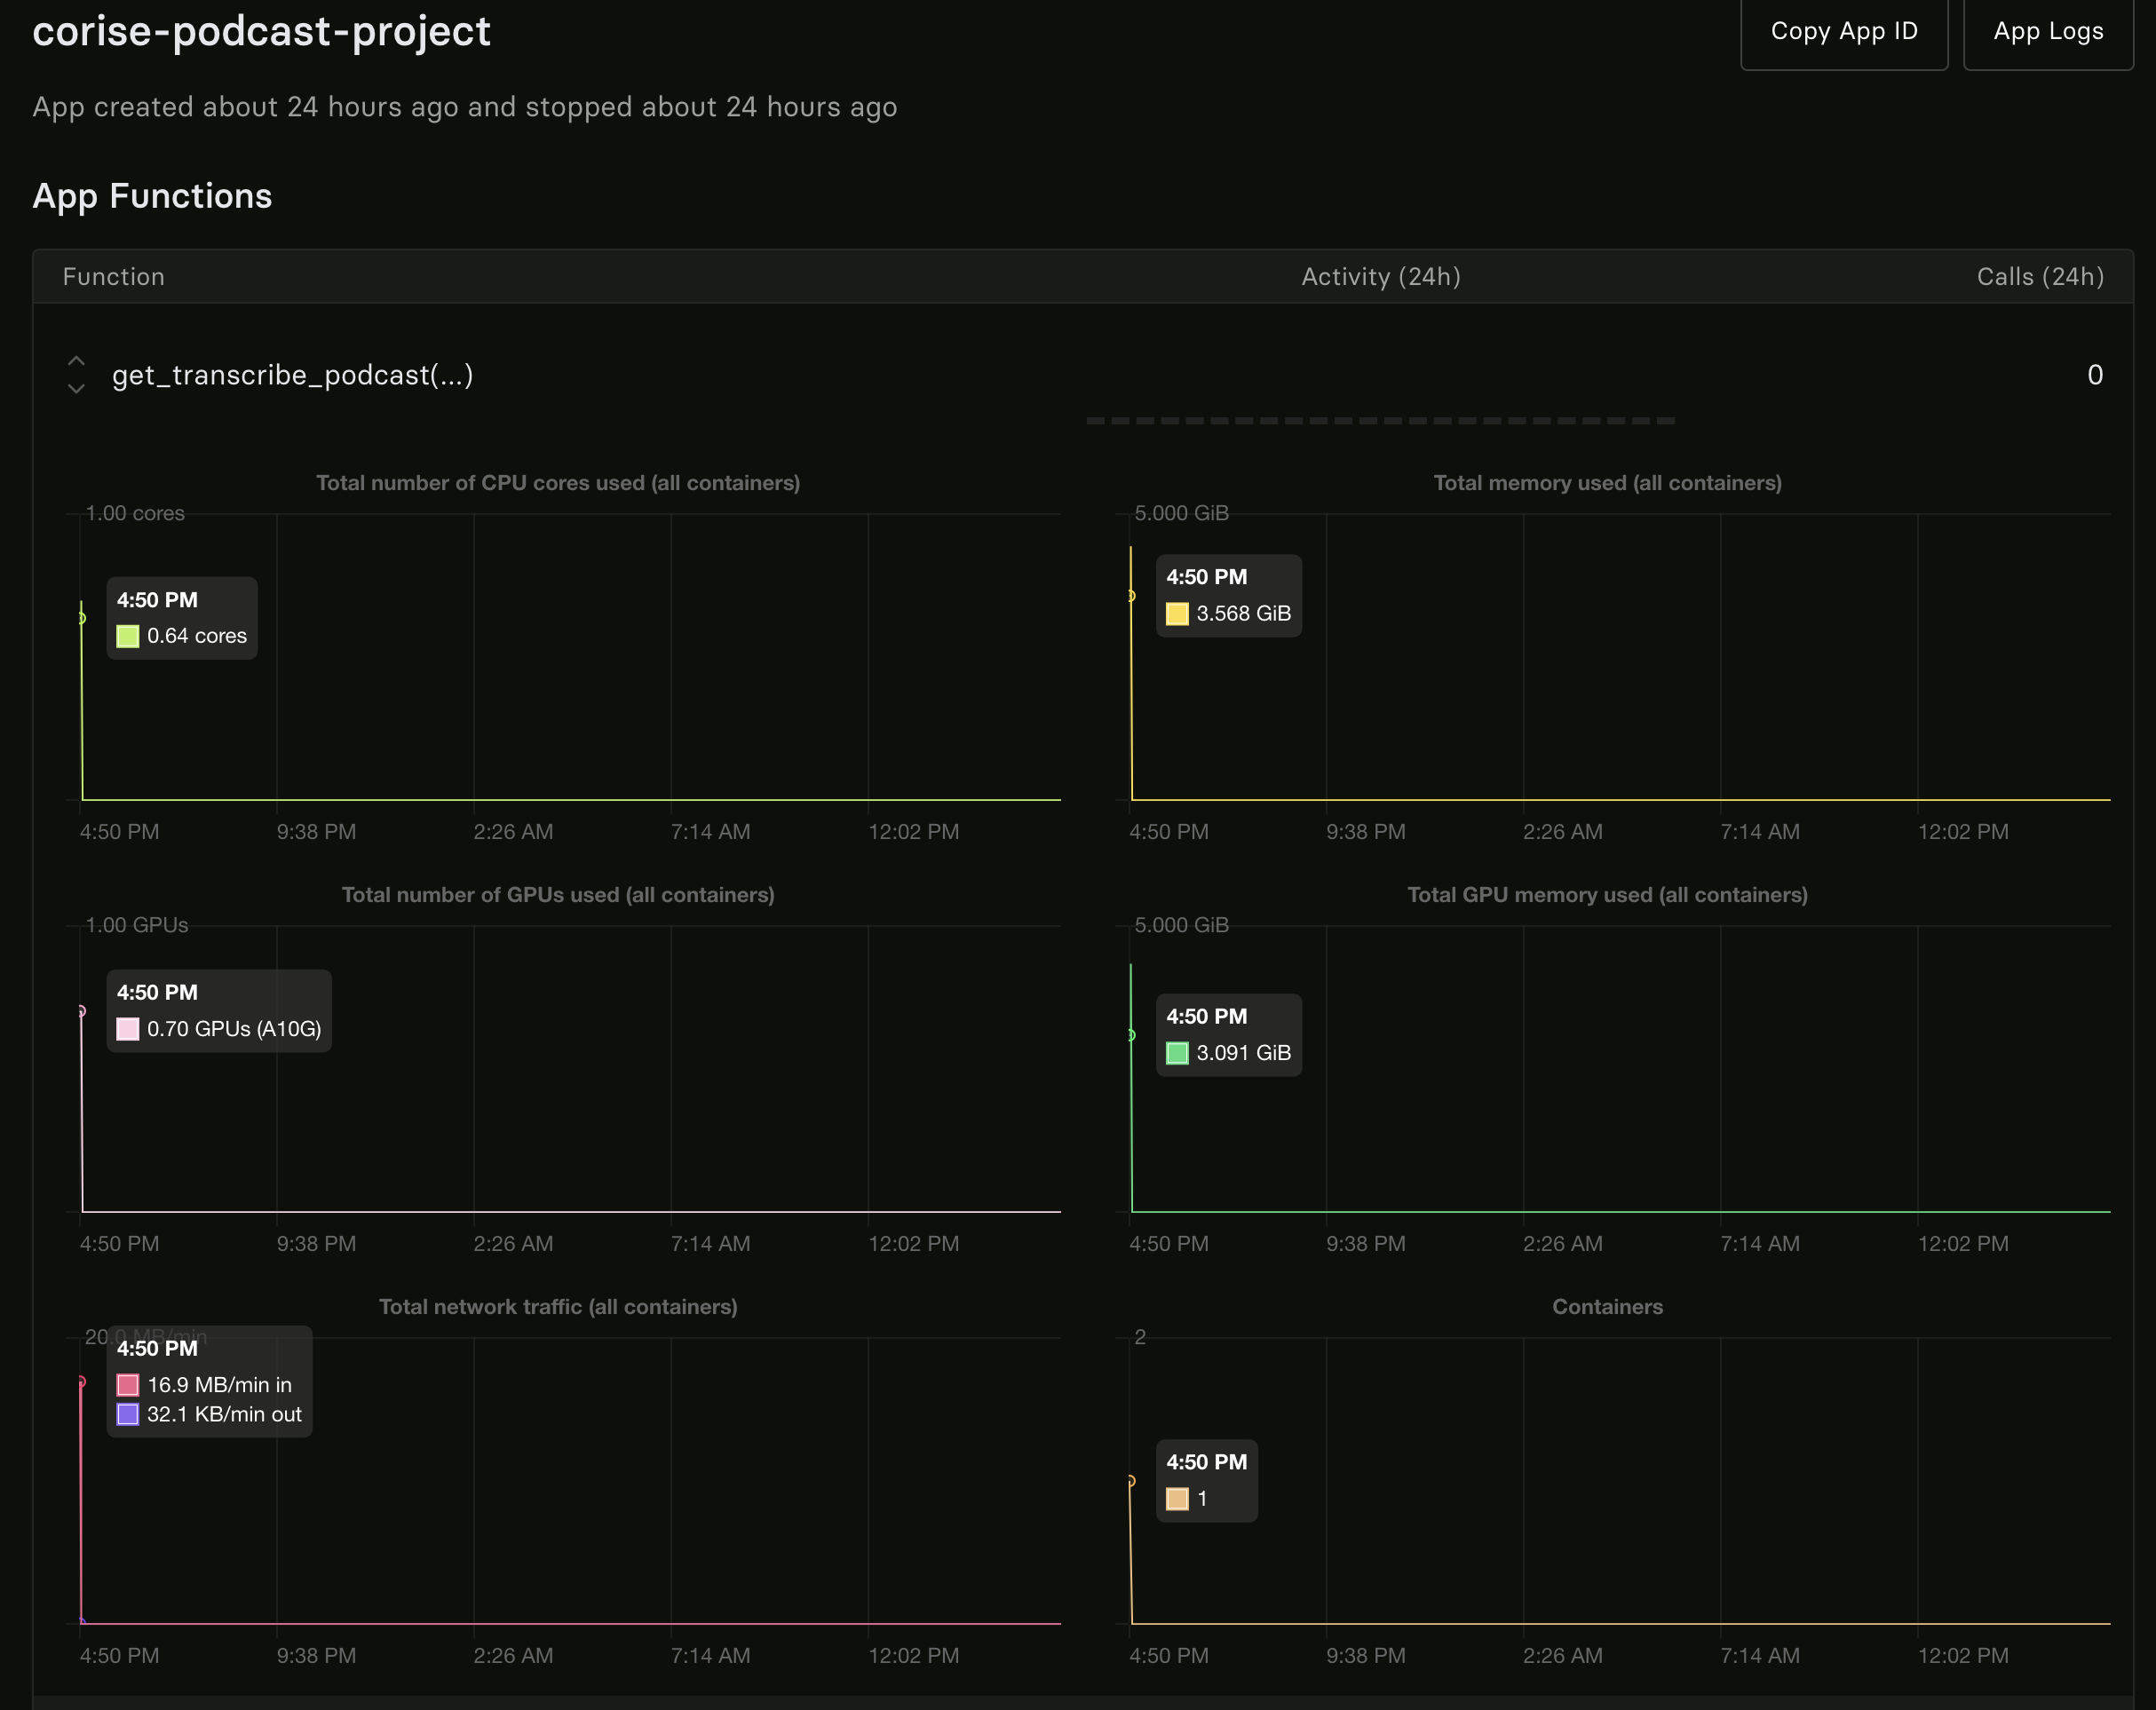

When the app has run, it prints the transcription in the logs. This is not ideal but we anyways will do further extraction steps and include the functions for it. The entire process runs for a few minutes on the GPU cloud and costs ~10-30 cts.

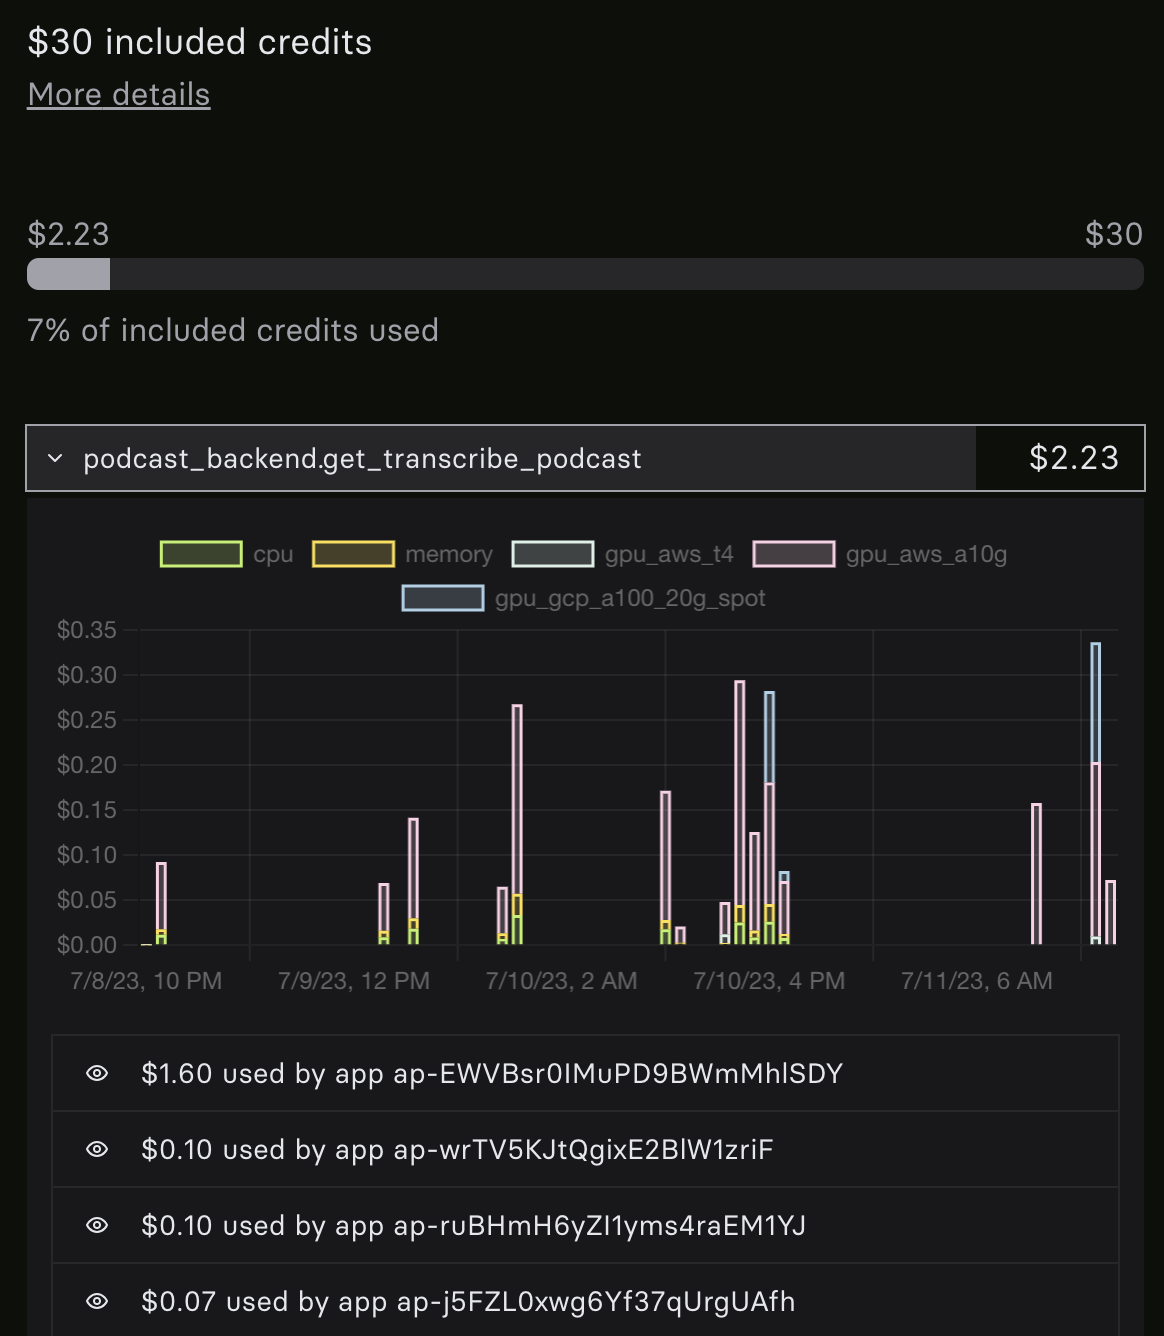

## Step 2 - Create a cloud information extraction function

Now we add the information extraction functions and deploy our end to end backend pipeline.

In [ ]:
from pathlib import Path
Path("/content/podcast/").mkdir(exist_ok=True)

In [ ]:
%%writefile /content/podcast/podcast_backend_trans_4.py
import modal

def download_whisper():
  # Load the Whisper model
  import os
  import whisper
  print ("Download the Whisper model")

  # Perform download only once and save to Container storage
  whisper._download(whisper._MODELS["medium"], '/content/podcast/', False)


stub = modal.Stub("corise-podcast-project")
corise_image = modal.Image.debian_slim().pip_install("feedparser",
                                                     "https://github.com/openai/whisper/archive/9f70a352f9f8630ab3aa0d06af5cb9532bd8c21d.tar.gz",
                                                     "requests",
                                                     "ffmpeg",
                                                     "openai",
                                                     "tiktoken",
                                                     "wikipedia",
                                                     "ffmpeg-python").apt_install("ffmpeg").run_function(download_whisper)

@stub.function(image=corise_image, gpu="A100", timeout=1200)
def get_transcribe_podcast(rss_url, local_path):
  print ("Starting Podcast Transcription Function")
  print ("Feed URL: ", rss_url)
  print ("Local Path:", local_path)

  # Read from the RSS Feed URL
  import feedparser
  intelligence_feed = feedparser.parse(rss_url)

  if isinstance(intelligence_feed['feed'], dict) and 'title' in intelligence_feed['feed']:
    # in case a user gives a link to a bad RSS feed, or no feed at all
    podcast_title = intelligence_feed['feed']['title']
  else:
    return None

  podcast_title = intelligence_feed['feed']['title']
  episode_title = intelligence_feed.entries[0]['title']
  episode_image = intelligence_feed['feed']['image'].href
  for item in intelligence_feed.entries[0].links:
    if (item['type'] == 'audio/mpeg'):
      episode_url = item.href
  episode_name = "podcast_episode.mp3"
  print ("RSS URL read and episode URL: ", episode_url)

  # Download the podcast episode by parsing the RSS feed
  from pathlib import Path
  p = Path(local_path)
  p.mkdir(exist_ok=True)

  print ("Downloading the podcast episode")
  import requests
  with requests.get(episode_url, stream=True) as r:
    r.raise_for_status()
    episode_path = p.joinpath(episode_name)
    with open(episode_path, 'wb') as f:
      for chunk in r.iter_content(chunk_size=8192):
        f.write(chunk)

  print ("Podcast Episode downloaded")

  # Load the Whisper model
  import os
  import whisper

  # Load model from saved location
  print ("Load the Whisper model")
  model = whisper.load_model('medium', device='cuda', download_root='/content/podcast/')

  # Perform the transcription
  print ("Starting podcast transcription")
  result = model.transcribe(local_path + episode_name)

  # Return the transcribed text
  print ("Podcast transcription completed, returning results...")
  output = {}
  output['podcast_title'] = podcast_title
  output['episode_title'] = episode_title
  output['episode_image'] = episode_image
  output['episode_transcript'] = result['text']
  return output

@stub.function(image=corise_image, secret=modal.Secret.from_name("my-openai-secret"))
def get_podcast_summary(podcast_transcript):
  import openai
  ## LOGIC TO RETURN THE SUMMARY OF THE PODCAST USING OPENAI
  instructPrompt = """Please summarize the following podcast transcript in one paragraph."""

  request = instructPrompt + podcast_transcript
  chatOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo-16k",
                                     messages=[{"role": "system", "content": "You are a helpful assistant."},
                                               {"role": "user", "content": request}]
                                    )
  podcastSummary = chatOutput.choices[0].message.content
  return podcastSummary

@stub.function(image=corise_image, secret=modal.Secret.from_name("my-openai-secret"))
def get_podcast_guest(podcast_transcript):
  import openai
  #import wikipedia
  import json
  import tiktoken
  ## LOGIC TO RETURN THE PODCAST GUEST INFORMATION
  request = podcast_transcript[:10000]
  enc = tiktoken.encoding_for_model("gpt-3.5-turbo")
  #print ("Number of tokens in input prompt ", len(enc.encode(request)))
  completion = openai.ChatCompletion.create(
      model="gpt-3.5-turbo",
      messages=[{"role": "user", "content": request}],
      functions=[
      {
          "name": "get_podcast_guest_information",
          "description": "Get information on the podcast guest using their full name and the name of the organization they are part of to search for them on Wikipedia or Google",
          "parameters": {
              "type": "object",
              "properties": {
                  "guest_name": {
                      "type": "string",
                      "description": "The full name of the guest who is speaking in the podcast",
                  },
                  "guest_organization": {
                      "type": "string",
                      "description": "The full name of the organization that the podcast guest belongs to or runs or works for",
                  },
                  "guest_title": {
                      "type": "string",
                      "description": "The title, designation or role of the podcast guest in their organization",
                  },
              },
              "required": ["guest_name"],
          },
      }
  ],
  function_call={"name": "get_podcast_guest_information"}
  )

  import json

  podcast_guest = ""
  podcast_guest_org = ""
  podcast_guest_title = ""

  response_message = completion["choices"][0]["message"]
  if response_message.get("function_call"):
    function_name = response_message["function_call"]["name"]
    function_args = json.loads(response_message["function_call"]["arguments"])
    podcast_guest=function_args.get("guest_name")
    print("podcast_guest extracted!")
    #podcast_guest_org=function_args.get("guest_organization")
    #podcast_guest_title=function_args.get("guest_title")
  return podcast_guest

@stub.function(image=corise_image, secret=modal.Secret.from_name("my-openai-secret"))
def get_podcast_highlights(podcast_transcript):
  import openai
  ### LOGIC TO RETURN THE HIGHLIGHTS OF THE PODCAST
  instructPrompt = """
  Read the following text transcript of a podcast and summarize it for readers, with bullet points.
  Stick to the content, do not add comments.
  """

  request = instructPrompt + podcast_transcript
  chatOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo-16k",
                                    messages=[{"role": "system", "content": "You are a helpful assistant."},
                                              {"role": "user", "content": request}
                                              ]
                                    )
  podcastHighlights = chatOutput.choices[0].message.content
  return podcastHighlights

@stub.function(image=corise_image, secret=modal.Secret.from_name("my-openai-secret"), timeout=1200)
def process_podcast(url, path):
  output = {}
  podcast_details = get_transcribe_podcast.call(url, path)
  # podcast_details={'episode_transcript':"Jesse Pollack, the creator of BASE, a Layer 2 scaling solution from Coinbase, discusses the origin and value proposition of BASE in a podcast interview. BASE is an Ethereum Layer 2 incubated by Coinbase and aims to make running applications on Ethereum cheaper and more accessible. Pollack explains that the decision to build BASE as a Layer 2 rather than a new Layer 1 was driven by the belief that multiple Layer 2 solutions will be needed to scale Ethereum and bring a billion people on-chain. He highlights the importance of decentralization in BASE and outlines the roadmap for further decentralization, including the development of a neutrality framework, technical decentralization, and sustainable funding. Pollack also discusses the challenges of high transaction fees on Layer 2s and the upcoming EIP-4844 upgrade, which aims to reduce fees and increase capacity. Finally, he shares his optimistic vision of a future where a billion people are on-chain and the positive impact it can have on economic freedom and creativity."}
  podcast_summary = get_podcast_summary.call(podcast_details['episode_transcript'])
  podcast_guest = get_podcast_guest.call(podcast_details['episode_transcript'])
  podcast_highlights = get_podcast_highlights.call(podcast_details['episode_transcript'])
  output['podcast_details'] = podcast_details
  output['podcast_summary'] = podcast_summary
  output['podcast_guest'] = podcast_guest
  output['podcast_highlights'] = podcast_highlights
  return output

@stub.local_entrypoint()
def test_method(url, path):
  output = {}
  podcast_details = get_transcribe_podcast.call(url, path)
  print ("Podcast Summary: ", get_podcast_summary.call(podcast_details['episode_transcript']))
  print ("Podcast Guest Information: ", get_podcast_guest.call(podcast_details['episode_transcript']))
  print ("Podcast Highlights: ", get_podcast_highlights.call(podcast_details['episode_transcript']))

Writing /content/podcast/podcast_backend_trans_4.py


In [ ]:
!cp /content/podcast/podcast_backend_trans_all3.py google_dir_path

I used an additional parameter called `secret` in the information extraction functions to pass the token needed by the OpenAI API. It's created on the Modal portal in `Settings` / `Create New Secret`. Select OpenAI and paste the token value. The chosen name of the secret (`my-openai-secret`) should match the one used in the function definition.

I could have created a new token on the OpenAI portal just for this, but I didn't.

Now let's our information extraction first.

In [ ]:
!modal run /content/podcast/podcast_backend_trans_4.py --url "https://anchor.fm/s/1bee9344/podcast/rss" --path /content/podcast/

✓ Initialized. View app at https://modal.com/apps/ap-rF7ZD869zCjzv8wjP3hAFa
⠋ Initializing...
⠹ Creating objects...
├── ⠋ Creating get_transcribe_podcast...
└── ⠋ Creating mount /content/podcast/podcast_backend_trans_all3.py: Uploaded 
⠴ Creating objects...
├── ⠸ Creating get_transcribe_podcast...
└── ⠸ Creating mount /content/podcast/podcast_backend_trans_all3.py: Uploaded 
⠇ Creating objects...
├── ⠦ Creating get_transcribe_podcast...
└── ⠦ Creating mount /content/podcast/podcast_backend_trans_all3.py: Uploaded 
⠹ Creating objects...
├── ⠏ Creating get_transcribe_podcast...
└── ⠏ Creating mount /content/podcast/podcast_backend_trans_all3.py: Building 
⠴ Creating objects...
├── ⠹ Creating get_transcribe_podcast...
⠇ Creating objects...
├── ⠴ Creating get_transcribe_podcast...
├── 🔨 Created mount /content/podcast/podcast_backend_trans_all3.py
├── ⠋ Creating download_whisper...
└── ⠋ Creating mount /content/podcast/podcast_backend_trans_all3.py: Uploaded 
⠙ Creating objects...
├── ⠇ Cre

It works as expected so I can deploy it to the Modal cloud so it can be called by Streamlit our front-end.

In [ ]:
!modal deploy /content/podcast/podcast_backend_trans_4.py

⠴ Creating objects...
├── ⠋ Creating get_transcribe_podcast...
└── ⠋ Creating mount /content/podcast/podcast_backend_trans_all3.py: Building 
⠇ Creating objects...
├── ⠸ Creating get_transcribe_podcast...
⠹ Creating objects...
├── ⠦ Creating get_transcribe_podcast...
⠴ Creating objects...
├── ⠏ Creating get_transcribe_podcast...
⠇ Creating objects...
├── ⠹ Creating get_transcribe_podcast...
├── 🔨 Created mount /content/podcast/podcast_backend_trans_all3.py
├── ⠋ Creating download_whisper...
└── ⠋ Creating mount /content/podcast/podcast_backend_trans_all3.py: Uploaded 
⠙ Creating objects...
├── ⠴ Creating get_transcribe_podcast...
├── 🔨 Created mount /content/podcast/podcast_backend_trans_all3.py
├── ⠸ Creating download_whisper...
└── ⠸ Creating mount /content/podcast/podcast_backend_trans_all3.py: Building 
⠼ Creating objects...
├── ⠇ Creating get_transcribe_podcast...
├── 🔨 Created mount /content/podcast/podcast_backend_trans_all3.py
├── ⠦ Creating download_whisper...
⠧ Creating objec

To test the deployed function, we can call it directly from this notebook using the project name that `modal deploy` just gave us, and call the deployed functions by providing podcast feeds URLs.

⚠️⚠️⚠️ ⏭ **IMPORTANT NOTE** ⏮ ⚠️⚠️⚠️

As previously mentioned, be wary of the time issues that long podcasts can bring.  

In [ ]:
# Trying to call the deployed function from another python session
import modal
f = modal.Function.lookup("corise-podcast-project", "process_podcast")
#output = f.call("https://anchor.fm/s/1bee9344/podcast/rss", '/content/podcast/')
#output = f.call('https://feeds.megaphone.fm/MLN2155636147', '/content/podcast/')
output = f.call("https://podcasters.spotify.com/pod/show/thedefiant/episodes/Base-Coinbases-New-Layer-2-Kicks-Off-e283psb", '/content/podcast/')

In [ ]:
import json
with open("/content/podcast/podcast-1bee9344.json", "w") as outfile:
  json.dump(output, outfile)

In [ ]:
from google.colab import files

files.download('/content/podcast/podcast-1bee9344.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In the above step we called our deployed function with an RSS feed of a podcast of our choice and saved the output. It takes a bit of time to run this function, approximately 5 mins for a 30 min podcast.

To save time for the demo, create a few json files to pre-populate the frontend.  

### Improvements
There are multiple ways to speed-up the transcription process which is what takes the most amount of time. We provide some hints below on libraries and approaches if you want to extend your project -

- There is a super fast [implementation](https://github.com/sanchit-gandhi/whisper-jax) of Whisper using JAX which could be a drop-in replacement
- There is alternate approach of splitting up the audio into chunks by detecting silences and then parallelising it using multiple Modal GPU containers. They provide a very nice [example](https://github.com/modal-labs/modal-examples/tree/main/06_gpu_and_ml/openai_whisper/pod_transcriber) of how to achieve this

# Part 3 - Deploying the front-end application with Streamlit

In the final part of our AI product let's create a front-end for our podcast summarizer application.

Let's experiment with Streamlit applications for the front-end so we can stick with Python and deploy it is easy without the typical tiresome frontend techs or deploying containerized app in a VPC.

In [ ]:
%%writefile /content/podcast/podcast_frontend.py
import streamlit as st
import modal
import json
import os

def main():
    st.title("Newsletter Dashboard")

    available_podcast_info = create_dict_from_json_files('.')

    # Left section - Input fields
    st.sidebar.header("Podcast RSS Feeds")

    # Dropdown box
    st.sidebar.subheader("Available Podcasts Feeds")
    selected_podcast = st.sidebar.selectbox("Select Podcast", options=available_podcast_info.keys())

    if selected_podcast:

        podcast_info = available_podcast_info[selected_podcast]

        # Right section - Newsletter content
        st.header("Newsletter Content")

        # Display the podcast title
        st.subheader("Episode Title")
        st.write(podcast_info['podcast_details']['episode_title'])

        # Display the podcast summary and the cover image in a side-by-side layout
        col1, col2 = st.columns([7, 3])

        with col1:
            # Display the podcast episode summary
            st.subheader("Podcast Episode Summary")
            st.write(podcast_info['podcast_summary'])

        with col2:
            st.image(podcast_info['podcast_details']['episode_image'], caption="Podcast Cover", width=300, use_column_width=True)

        # Display the podcast guest and their details in a side-by-side layout
        col3, col4 = st.columns([3, 7])

        with col3:
            st.subheader("Podcast Guest")
            st.write(podcast_info['podcast_guest']['name'])

        with col4:
            st.subheader("Podcast Guest Details")
            st.write(podcast_info["podcast_guest"]['summary'])

        # Display the five key moments
        st.subheader("Key Moments")
        key_moments = podcast_info['podcast_highlights']
        for moment in key_moments.split('\n'):
            st.markdown(
                f"<p style='margin-bottom: 5px;'>{moment}</p>", unsafe_allow_html=True)

    # User Input box
    st.sidebar.subheader("Add and Process New Podcast Feed")
    url = st.sidebar.text_input("Link to RSS Feed")

    process_button = st.sidebar.button("Process Podcast Feed")
    st.sidebar.markdown("**Note**: Podcast processing can take upto 5 mins, please be patient.")

    if process_button:

        # Call the function to process the URLs and retrieve podcast guest information
        podcast_info = process_podcast_info(url)

        if podcast_info is None:
            st.header('Sorry, we could not process your podcast feed. Please try again.')
            return

        # Right section - Newsletter content
        st.header("Newsletter Content")

        # Display the podcast title
        st.subheader("Episode Title")
        st.write(podcast_info['podcast_details']['episode_title'])

        # Display the podcast summary and the cover image in a side-by-side layout
        col1, col2 = st.columns([7, 3])

        with col1:
            # Display the podcast episode summary
            st.subheader("Podcast Episode Summary")
            st.write(podcast_info['podcast_summary'])

        with col2:
            st.image(podcast_info['podcast_details']['episode_image'], caption="Podcast Cover", width=300, use_column_width=True)

        # Display the podcast guest and their details in a side-by-side layout
        col3, col4 = st.columns([3, 7])

        with col3:
            st.subheader("Podcast Guest")
            st.write(podcast_info['podcast_guest']['name'])

        with col4:
            st.subheader("Podcast Guest Details")
            st.write(podcast_info["podcast_guest"]['summary'])

        # Display the five key moments
        st.subheader("Key Moments")
        key_moments = podcast_info['podcast_highlights']
        for moment in key_moments.split('\n'):
            st.markdown(
                f"<p style='margin-bottom: 5px;'>{moment}</p>", unsafe_allow_html=True)

def create_dict_from_json_files(folder_path):
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
    data_dict = {}

    for file_name in json_files:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            podcast_info = json.load(file)
            podcast_name = podcast_info['podcast_details']['podcast_title']
            # Process the file data as needed
            data_dict[podcast_name] = podcast_info

    return data_dict

def process_podcast_info(url):
    f = modal.Function.lookup("corise-podcast-project", "process_podcast")
    output = f.call(url, '/content/podcast/')
    return output

if __name__ == '__main__':
    main()

Writing /content/podcast/podcast_frontend.py


The previous step wrote a python file containing all the code for our Streamlit front-end. Now we download it locally.

In [ ]:
from google.colab import files

# Download the file locally
files.download('/content/podcast/podcast_frontend.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We also need to create a `requirements.txt` with the dependencies.

In [ ]:
%%writefile /content/podcast/requirements.txt
streamlit
modal

Writing /content/podcast/requirements.txt


In [ ]:
from google.colab import files

# Download the file locally
files.download('/content/podcast/requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Finally, we want to pre-populate the streamlit app with some pre-processed podcasts in json format.

In [ ]:
from google.colab import files

# Download the file locally
files.download('/content/podcast/podcast-1.json')
files.download('/content/podcast/podcast-2.json')
files.download('/content/podcast/podcast-3.json')

### Upload the following files to a Github repo for Streamlit

- `podcast_frontend.py`
- `requirements.txt`
- `podcast-1.json`
- `podcast-2.json`
- `podcast-3.json`

The Streamlit cloud app pulls the code directly from the github repo. Once it is deployed, any changes to the files in the repo are automatically reflected in the app!



Here you can provide the following information:
- **Repository name**: you can pick the name of your product
- **License**: you can choose any license
- **Public or private?** you need to have a public repo in order for Streamlit Share to pull the code

Then upload the files that you downloaded previously to this URL below. ***Please modify it before copy-pasting it***:

```https://github.com/[YOUR_ACCOUNT_NAME]/[YOUR_REPOSITORY_NAME]/upload/main```

### Create a Streamlit Share App

We have uploaded files to a repo and now we initialize the Streamlit app. Use the Github repo to allows Streamlit to easily pull the code for the app.

Then, select New app > Deploy a new app... > From existing repo.

### Adding Modal secrets

Since we call the cloud-deployed function directly from the app, we also need to authenticate with Modal. For this, add the MODAL_TOKEN_ID and MODAL_TOKEN_SECRET to the secrets part of the Streamlit app.  Paste them in `Advanced settings`.

If everything is done correctly, calling the <function name>.streamlit.app will show the following.

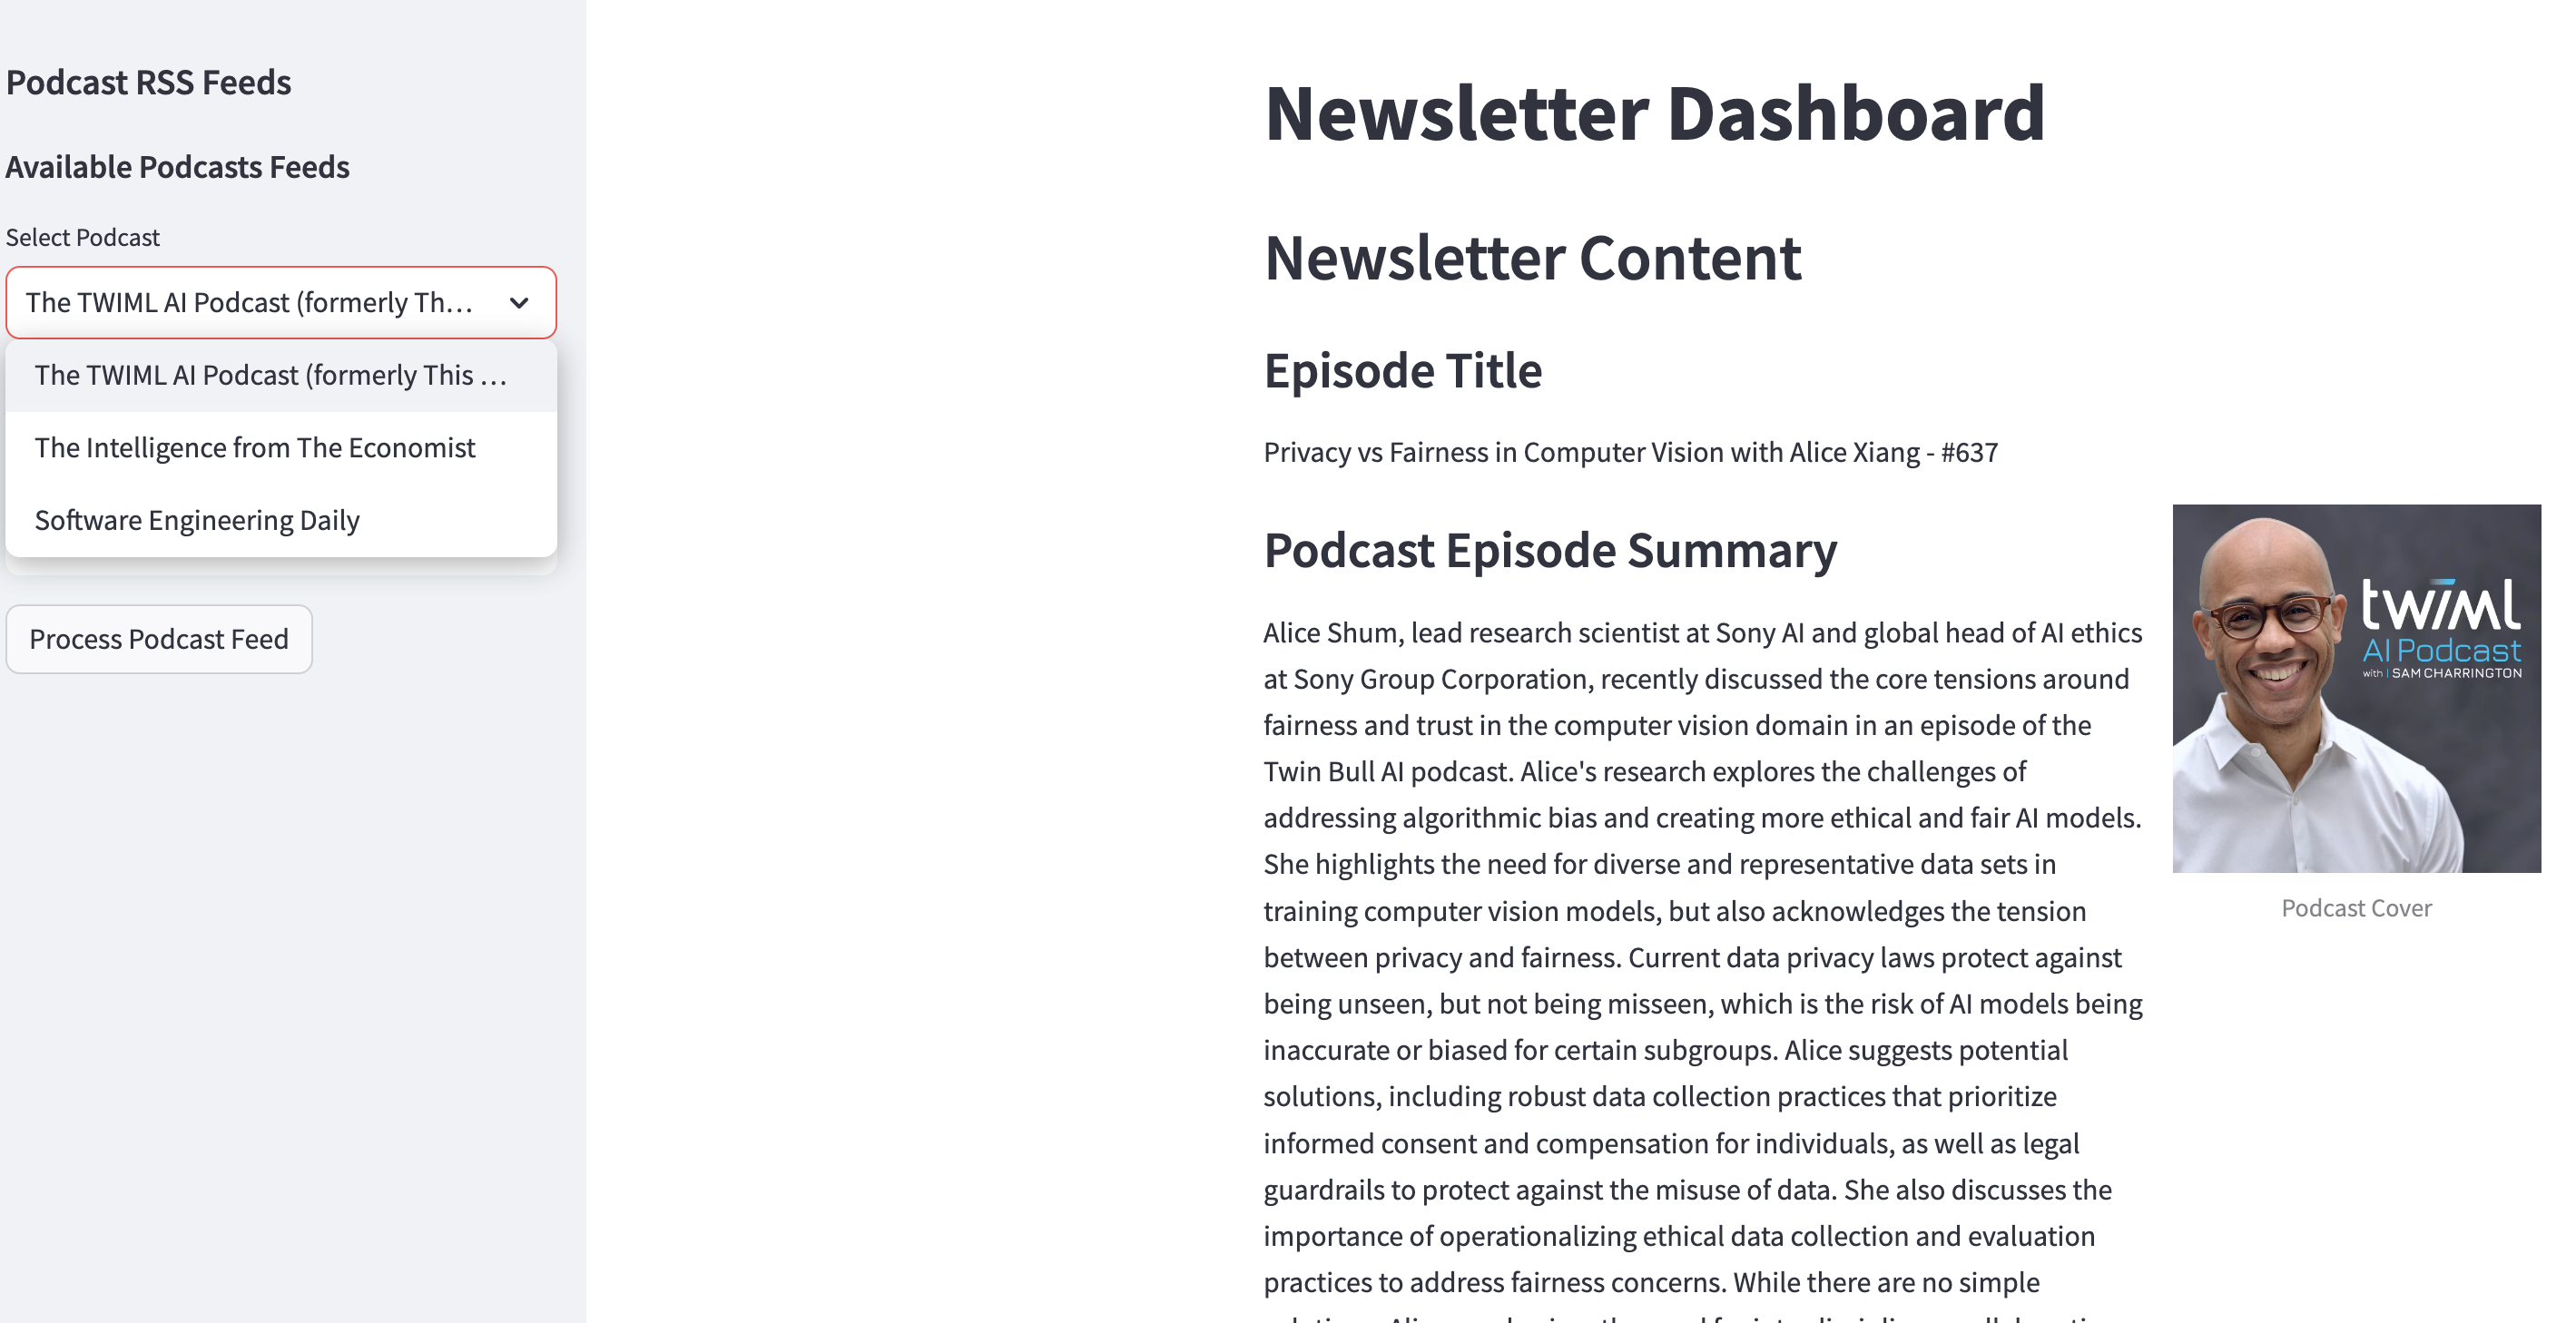